# Age Estimation task

## Imports

In [67]:
import numpy as np
import pandas as pd
import scipy
from scipy.io import wavfile
from scipy.stats import skew, kurtosis

# for regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import statistics

import seaborn as sns

# for audio processing
import os
import librosa
import librosa.display
import librosa.feature
import noisereduce as nr
import parselmouth as pm
import maad as maad
from maad import features
import parselmouth
from parselmouth.praat import call

from joblib import Parallel, delayed
from tqdm import tqdm

# for layout
from prettytable import PrettyTable
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore")

# %matplotlib widget

## Constants

In [2]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

AUDIOS_DEVELOPMENT_CLEANED = "Dataset/audios_development_cleaned/"
AUDIOS_EVALUATION_CLEANED = "Dataset/audios_evaluation_cleaned/"

COMPUTE_ALL = False

N_MFCC = 20
FREQ_BIN = 32

precisionLog = {
    'mean_pitch':2, 
    'max_pitch':2, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

precisionLinear = {
    'mean_pitch':-1, 
    'max_pitch':-2, 
    'min_pitch':0, 
    'jitter':3, 
    'shimmer':3, 
    'energy':3, 
    'zcr_mean':2, 
    'spectral_centroid_mean':-2,
    'tempo':3,
    'hnr':0
}

columns_correlator = {
    k:v for k,v in zip(
        [
            "time_domain.csv", "freq_domain.csv", "spectrogram.csv", "mel_spectrogram.csv", "mfcc.csv", "hpss.csv", "zcr.csv", "poly.csv", "formants.csv"
        ], 
        [
            ['audio_length', 'mean_absolute_slope', 'median_pitch', 'median_pitch_strength', 'pitch_iqr'], 
            ['dominant_frequency', 'highest_freq_in_spectrum', 'lowest_freq_in_spectrum', 'spectrum_wide'], 
            ['spect_overall_mean', 'spect_overall_var'] + [f"spect_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"spect_frequency_var_{t}" for t in range(FREQ_BIN)],
            ['mel_overall_mean', 'mel_overall_var'] + [f"mel_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"mel_frequency_var_{t}" for t in range(FREQ_BIN)],
            ['mfcc_overall_mean', 'mfcc_overall_var'] + [f"mfcc_frequency_mean_{t}" for t in range(N_MFCC)] + [f"mfcc_frequency_var_{t}" for t in range(N_MFCC)],
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var'] + [f"harmonic_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"harmonic_frequency_var_{t}" for t in range(FREQ_BIN)] + [f"percussion_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"percussion_frequency_var_{t}" for t in range(FREQ_BIN)],
            ['zcr'],
            ['mean_coeffs', 'std_coeffs'],
            ['f0']
        ]
    )
}

## Data reading

In [3]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

audio_dev = os.listdir(AUDIOS_DEVELOPMENT)
audio_eval = os.listdir(AUDIOS_EVALUATION)

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '10.wav', '100.wav', '1000.wav', '1001.wav']
['1.wav', '10.wav', '100.wav', '101.wav', '102.wav']


Order audios by integers and increasing order

In [4]:
audio_dev.sort(key=lambda x: int(x.split('.')[0]))
audio_eval.sort(key=lambda x: int(x.split('.')[0]))

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']
['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']


## Tabular Data Exploration

In [5]:
# display(dev_original_df.head())

display(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}")
display(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

display(desc_dev_df.loc['std', 'sampling_rate'])
display(desc_eval_df.loc['std', 'sampling_rate'])

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df = dev_df.drop(['path'], axis=1)
eval_df = eval_df.drop('path', axis=1)

display(dev_df.head())
display(eval_df.head())

'Total number of nan in development: 0'

'Total number of nan in evaluation: 0'

np.float64(0.0)

np.float64(0.0)

,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905


,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,[80.74951172],-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,[89.10290948],-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,[123.046875],-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,[123.046875],-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,[112.34714674],-134.914070,69,281,35,22.430476


In [6]:
et = dev_df['ethnicity'].value_counts()
et

ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, Length: 165, dtype: int64

## Preprocess tabular data

### Encoding

#### Ethnicity

In [7]:
def encode_english(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['english'] = (X_copy['ethnicity'] == 'english').astype(int)
    X_copy['others'] = (X_copy['ethnicity'] != 'english').astype(int)

    return X_copy.drop(columns='ethnicity', axis=1)

In [8]:
def encode_ethnicity(X_df, ethnie):
    aggregated_ethnicity_df = X_df.copy()

    # etna = pd.DataFrame(1, columns=ethnie, index=X_df.index, dtype=float)

    # aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'].isin(ethnie)), 'ethnicity'] = 'others'

    # for etnia in ethnie:
    #     aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = etna[etnia]

    #     # aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = 1
    #     aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'] == etnia), etnia] = 0

    # # encoded_ethnicity = pd.get_dummies(aggregated_ethnicity_df['ethnicity'], dtype=int)

    try:
        aggregated_ethnicity_df = aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1)
    except KeyError:
        pass

    return aggregated_ethnicity_df

In [9]:
enticity_df = dev_df['ethnicity'].value_counts().sort_values(ascending=False)

median_et = enticity_df.median()
display(enticity_df[enticity_df == 1].shape)
display(enticity_df.head(20))
display(enticity_df.tail(10))
# enticity_df[enticity_df > median_et].plot()

# etnie_chosen = sorted(list(set(enticity_df[enticity_df > median_et].index))) + ['others']
etnie_chosen = ['english','igbo']
display(etnie_chosen)
display(etnie_chosen.__len__())

(58,)

ethnicity
igbo          1081
english        579
arabic         102
mandarin        65
french          63
korean          52
portuguese      48
russian         48
dutch           47
german          36
polish          34
italian         33
urhobo          32
japanese        27
ibibio          27
macedonian      26
farsi           23
cantonese       23
igala           22
amharic         20
Name: count, dtype: int64

ethnicity
faroese        1
nandi          1
nuer           1
dinka          1
mortlockese    1
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, dtype: int64

['english', 'igbo']

2

#### Gender

In [10]:
def encode_gender_one_hot(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['male'] = (X_copy['gender'] == 'male').astype(int)
    X_copy['female'] = (X_copy['gender'].isin(['female','famale'])).astype(int)

    return X_copy.drop(columns='gender', axis=1)

In [11]:
GenderMapper = {
    'male': 1,
    'female': -1
}

def encode_gender(X_df:pd.DataFrame, mapper):
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = GenderMapper['female']

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df

#### Tempo

In [12]:
# display(encoded_gender_etnicity_df['tempo'])

def encode_tempo(X_df):
    encoded_df = X_df.copy()
    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    return encoded_df


#### Results

In [13]:
display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

# FOR NOW, WE WILL DROP ETHNICITY #TODO:

# step1_dev_df = dev_df.drop(columns='ethnicity', axis=1)
# step1_eval_df = eval_df.drop(columns='ethnicity', axis=1)

# step1_dev_df = encode_english(dev_df)
# step1_eval_df = encode_english(eval_df)

step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# step2_dev_df = encode_gender_one_hot(step1_dev_df)
# step2_eval_df = encode_gender_one_hot(step1_eval_df)

step2_dev_df = encode_gender(step1_dev_df, GenderMapper)
step2_eval_df = encode_gender(step1_eval_df, GenderMapper)

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
display(step3_eval_df.head(5))

# display(step3_eval_df[step3_eval_df['yoruba'] == 1])
# display(eval_df.loc[75, :])

display(step3_dev_df.describe())
display(step3_eval_df.describe())

ethnicity
igbo    232
Name: count, dtype: int64

,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,24.0,-1.0,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,-1.0,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,-1.0,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,-1.0,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,1.0,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,
0,1.0,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,69,281,2,38.198503
1,1.0,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,69,281,27,29.605442
2,1.0,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,6,22,2,2.275556
3,-1.0,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,69,281,31,22.151837
4,1.0,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,69,281,35,22.430476


,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,27.897886,-0.001023,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,125.085771,-74.526288,41.307535,167.936243,12.423116,13.501159
std,13.093316,1.000170,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,33.812698,38.446856,32.782431,133.816974,14.273205,10.839142
min,6.000000,-1.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,51.679688,-193.693345,0.000000,0.000000,1.000000,0.668345
25%,19.000000,-1.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,103.359375,-104.555692,4.000000,14.000000,1.000000,1.732925
50%,23.000000,-1.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,117.453835,-84.415550,69.000000,281.000000,8.000000,17.368526
75%,32.000000,1.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,143.554688,-40.339359,69.000000,281.000000,20.000000,21.408798
max,97.000000,1.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,287.109375,12.403661,69.000000,281.000000,97.000000,83.777596


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,0.137482,1191.041077,3832.214580,146.591685,0.021320,0.110438,0.005074,0.105111,2214.701841,126.437846,-84.551539,43.946454,178.522431,15.698987,14.982523
std,0.991222,379.826928,451.201809,3.212186,0.006399,0.029365,0.005430,0.050162,571.250581,33.134285,36.514264,32.019084,130.933540,16.957466,11.040405
min,-1.000000,419.396150,1151.012200,145.349230,0.009395,0.035001,0.000056,0.018496,803.534172,54.978391,-155.826124,0.000000,0.000000,1.000000,0.925669
25%,-1.000000,865.617580,3955.649050,145.401825,0.017184,0.089501,0.001851,0.064549,1785.536118,103.359375,-112.362377,5.000000,17.000000,1.000000,2.115329
50%,1.000000,1209.680400,3998.631300,145.529140,0.020670,0.106233,0.003582,0.098416,2174.406614,123.046875,-92.686476,69.000000,281.000000,11.000000,18.552744
75%,1.000000,1487.326050,3999.521850,146.396920,0.024536,0.126537,0.006147,0.135834,2580.589333,143.554688,-59.687405,69.000000,281.000000,26.000000,23.010975
max,1.000000,2201.411000,3999.790800,186.688950,0.077450,0.246068,0.048074,0.335676,4753.076563,258.398438,11.653742,69.000000,281.000000,76.000000,57.663855


### Behavior analysis and $log_{10}$ scaling

#### Insight

In [14]:
def create_colors(values:pd.Series, label:str, use_continous:bool=False, 
                  cmap_continuous = cm.viridis, cmap_discrete = cm.rainbow):
    if use_continous:
        cmap_ = cmap_continuous
        # Alternative normalization without iterquartile ranges:
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap_)
        handles = None
    else:
        cmap_ = cmap_discrete
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = None
        handles = [
            Line2D(
                [0], [0], marker='o', color='none', linestyle='None', 
                markeredgewidth=0, markerfacecolor=cmap_(norm(val)), 
                markersize=10, label=label
            ) for label, val in GenderMapper.items()
        ]

    return cmap_, norm, mappable, handles 

def round_column(data: pd.DataFrame, col: str, isLog:bool = True):
    if col != 'hnr':
        if isLog:
            rounded_col = np.round(
                np.log10(data[col]), 
                precisionLog[col]
            )
        else:
            rounded_col = np.round(
                data[col],
                precisionLinear[col]
            )
    else:
        rounded_col = np.round(data[col], precisionLinear[col])
    return rounded_col


def perform_aggregation(partition_df, target, gender, descrete):
    grouped_temp = partition_df.groupby(col).agg({
        'frequency': 'first',
    })

    if not descrete:
        grouped_temp['target'] = grouped_temp.index.map(
            lambda val: target.loc[partition_df[partition_df[col] == val].index, :].mean().iloc[0]
        )
    else:
        grouped_temp['target'] = GenderMapper[gender]

    grouped_temp = grouped_temp.reset_index()

    return grouped_temp
    
def plot_distribution(fig:plt.Figure, ax:plt.Axes, X_df:pd.DataFrame, col:str, target:pd.Series, isLog:bool=True, descrete:bool=False):    
    temp = X_df[['gender', col]].copy()

    temp[col] = round_column(temp, col, isLog=isLog)

    male_df = temp[temp['gender'] == GenderMapper['male']].copy()
    female_df = temp[temp['gender'] == GenderMapper['female']].copy()

    male_df['frequency'] = male_df[col].map(male_df[col].value_counts())
    female_df['frequency'] = female_df[col].map(female_df[col].value_counts())

    male_grouped_df = perform_aggregation(male_df, target, 'male', descrete)
    female_grouped_df = perform_aggregation(female_df, target, 'female', descrete)

    female_grouped_df.index = female_grouped_df.index + male_grouped_df.index[-1]

    combined_df = pd.concat([male_grouped_df, female_grouped_df]).reset_index()

    cmap_, norm, mappable, handles = create_colors(combined_df.loc[:, 'target'], label='gender', use_continous=not descrete)

    sc = ax.scatter(combined_df[col], 
                    combined_df['frequency'], 
                    c=cmap_(norm(combined_df['target'])), 
                    alpha=0.7)

    if mappable:
        fig.colorbar(mappable=mappable, ax=ax)
    else:
        ax.legend(handles=handles)

#TODO: without 'gender' column does not work
def tabular_data_distribution():
    for i in range(9):
        col = list(precisionLog.keys())[i]
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in log10 scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, ages_df, isLog=True, descrete=True)
        ax1.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")

        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=True, descrete=False)
        ax2.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        plt.show()

        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
        ax1.set_xlabel(f'{col.capitalize()}')
        ax2.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")
        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
        ax2.set_ylabel(f'Count')
        ax2.set_xlabel(f'{col.capitalize()}')
        plt.show()


    col = list(precisionLog.keys())[9]

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
    ax1.set_xlabel(f'{col.capitalize()}')
    ax1.set_ylabel(f'Count')

    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")
    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
    ax2.set_xlabel(f'{col.capitalize()}')
    ax2.set_ylabel(f'Count')
    plt.show()

#### In practice

In [15]:
step3_log_dev_df = step3_dev_df.copy()
step3_log_eval_df = step3_eval_df.copy()

# for i, toSub in zip(precisionLog.keys(), [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]):
#     if toSub == 1:
#         step3_log_dev_df.loc[:, i] = np.log10(step3_dev_df.loc[:, i])
#         step3_log_eval_df.loc[:, i] = np.log10(step3_eval_df.loc[:, i])

## Correlation

age                 1.000000
silence_duration    0.514127
num_words           0.473499
num_characters      0.473403
num_pauses          0.437670
mean_pitch          0.315645
zcr_mean            0.278430
jitter              0.238498
max_pitch           0.226643
shimmer             0.204140
Name: age, dtype: float64

zcr_mean                  0.278430
jitter                    0.238498
max_pitch                 0.226643
shimmer                   0.204140
spectral_centroid_mean    0.044899
gender                    0.023184
energy                    0.020892
tempo                    -0.040547
min_pitch                -0.224201
hnr                      -0.446880
Name: age, dtype: float64

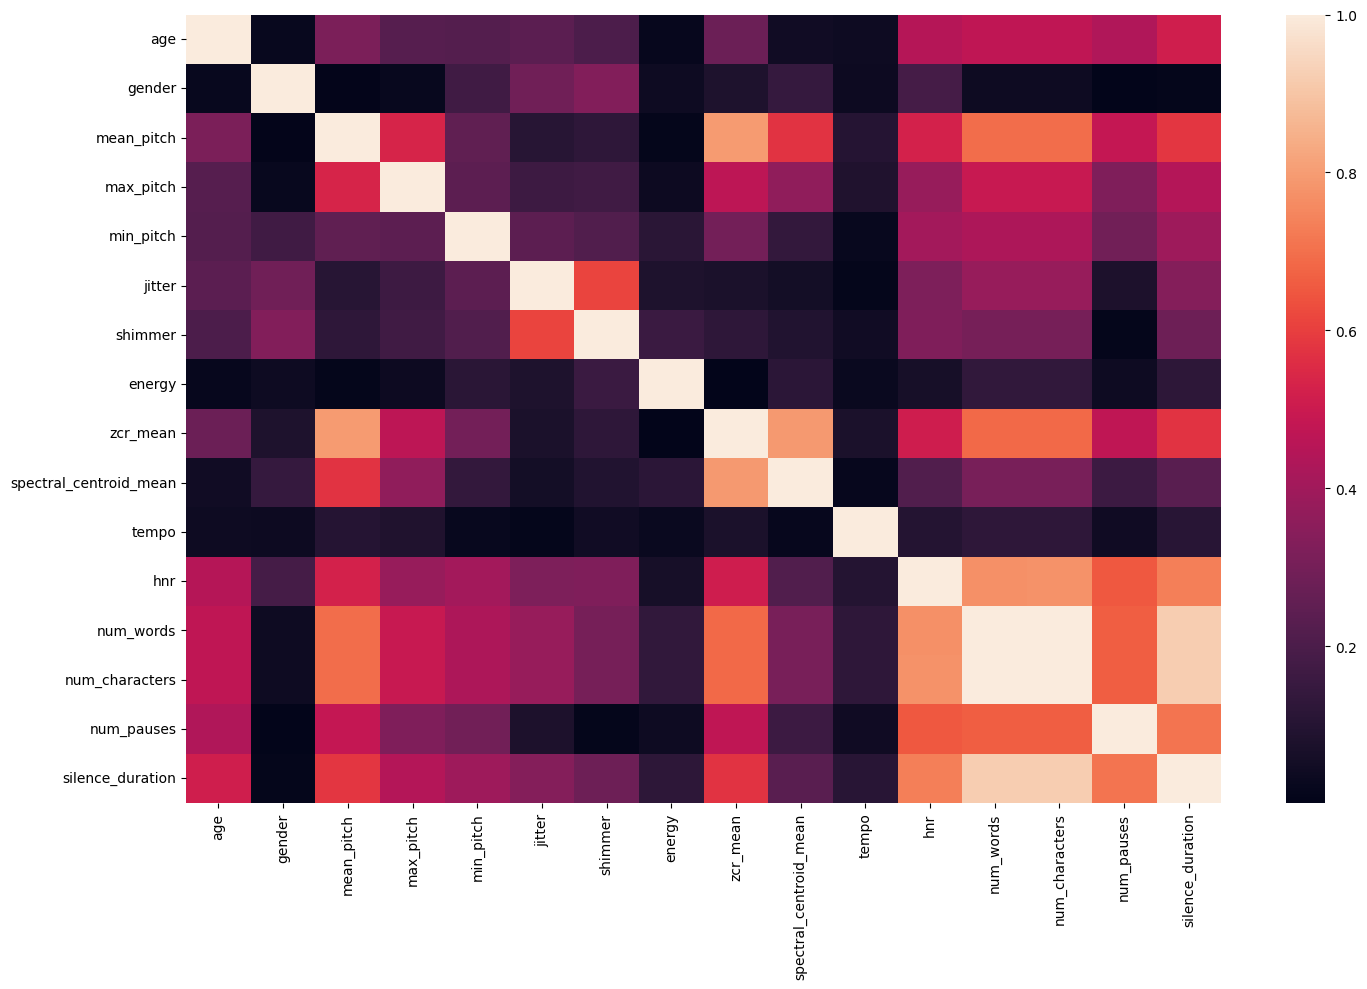

In [16]:
temp:pd.Series = step3_log_dev_df.corr().loc['age', :].sort_values(ascending=False)
display(temp.head(10))
display(temp.tail(10))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(np.abs(step3_log_dev_df.corr()), ax=ax)
plt.tight_layout()

### Standardization

In [17]:
no_age_dev_df = step3_log_dev_df.drop(columns=['age'], axis=1)

scaler = StandardScaler().fit(no_age_dev_df)

step3_log_norm_dev_df = pd.DataFrame(scaler.transform(no_age_dev_df), columns=no_age_dev_df.columns)
step3_log_norm_eval_df = pd.DataFrame(scaler.transform(step3_log_eval_df), columns=step3_log_eval_df.columns)

display(step3_log_norm_dev_df.head())
display(step3_log_norm_eval_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,-0.998978,1.526488,0.413221,-0.400362,-1.116336,-0.862609,-0.486481,2.039603,1.616870,0.796088,-1.287020,0.844879,0.845057,1.862330,0.954642
1,-0.998978,0.261473,0.411611,-0.415793,0.627830,-0.396497,0.429809,-0.502063,-0.843696,0.121675,-0.322635,0.844879,0.845057,0.601010,0.543263
2,-0.998978,0.346071,0.411505,-0.402148,-0.320350,0.403982,-0.367850,0.011442,0.691972,-0.225751,-0.622378,0.844879,0.845057,-0.800455,0.751095
3,-0.998978,0.581502,0.410845,0.278367,-0.631887,-0.184536,2.825886,1.334833,1.888962,-0.225751,0.469989,0.844879,0.845057,-0.239869,0.566836
4,1.001023,1.205407,0.411146,-0.395821,1.032230,0.589336,0.026396,0.048513,-0.424086,-0.376805,-0.151479,0.844879,0.845057,-0.099722,0.418993


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,1.001023,-0.320241,0.310818,-0.411849,0.134684,2.184013,-0.341252,-1.390696,-1.082816,-1.311455,-1.096143,0.844879,0.845057,-0.730382,2.278922
1,1.001023,0.102166,0.412198,-0.364788,0.812343,0.856721,0.259332,0.370281,0.291016,-1.064363,-0.096969,0.844879,0.845057,1.021450,1.486006
2,1.001023,-0.558399,-0.627155,-0.335666,-0.474905,-0.394877,-0.120197,-0.302604,-0.409095,-0.060310,0.075326,-1.077210,-1.090752,-0.730382,-1.035831
3,-0.998978,0.499864,0.411678,-0.405267,0.920924,-0.649645,1.594610,-0.149515,-0.594843,-0.060310,-0.702563,0.844879,0.845057,1.301743,0.798232
4,1.001023,1.072945,0.413308,-0.418335,0.065148,-0.133977,-0.632135,0.700578,0.618910,-0.376805,-1.570950,0.844879,0.845057,1.582037,0.823943


## Error plot

In [18]:
def plot_error_distripution(y_pred, y_val, precision):
    errors = pd.DataFrame(np.round(y_pred.flatten() - y_val.values.flatten(), precision), columns=['error'])
    error_counts = errors['error'].value_counts().reset_index()
    error_counts.columns = ['error', 'count']

    plt.figure()
    plt.scatter(error_counts['error'], error_counts['count'])
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    return error_counts

In [19]:
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

# cross_val_score(make_pipeline(StandardScaler(), RandomForestRegressor()), step3_log_dev_df, ages_df, cv=15, scoring='neq_mean_squared_error').mean().abs()

In [20]:
# let us try several models
models =[
    LinearRegression(),
    RandomForestRegressor(random_state=341967),
    HistGradientBoostingRegressor(random_state=341967),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(random_state=341967),
    Lasso(random_state=341967),
    Ridge(random_state=341967),
    DecisionTreeRegressor(random_state=341967)
]

names=['Linear reg', 'Random Forest', 'HistGB', 'SVR', 'KNN', 'MLP', 'Lasso', 'Ridge', 'Decision Tree']

In [21]:
t = PrettyTable(['Model', 'RMSE'])
X_train_val_df = step3_log_norm_dev_df.copy()

for model,name in zip(models, names):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    t.add_row([name, root_mean_squared_error(y_val, y_pred)])
print(t)

+---------------+--------------------+
|     Model     |        RMSE        |
+---------------+--------------------+
|   Linear reg  | 11.074781329346438 |
| Random Forest | 10.950182104309812 |
|     HistGB    | 10.858568901060597 |
|      SVR      | 11.405834095988084 |
|      KNN      | 12.133052832621404 |
|      MLP      | 10.776293727369621 |
|     Lasso     | 11.179462621957354 |
|     Ridge     | 11.068962735040156 |
| Decision Tree | 15.79829201731615  |
+---------------+--------------------+


## First regressor

10.950182104309812

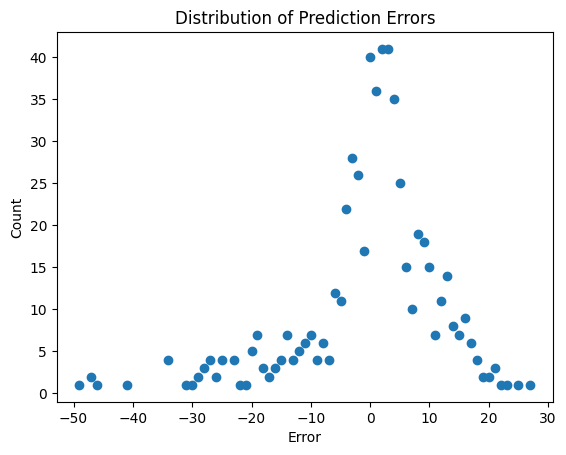

In [22]:
X_train_val_df = step3_log_norm_dev_df.copy()
# X_train_val_df = X_train_val_df.drop(columns=[], axis=1)

forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

First look to feature importances

In [23]:
imps =sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)
imps

[('silence_duration', np.float64(0.34097208305010585)),
 ('hnr', np.float64(0.07308107428701854)),
 ('jitter', np.float64(0.06424306744996193)),
 ('spectral_centroid_mean', np.float64(0.06205885974160902)),
 ('shimmer', np.float64(0.06191911252022544)),
 ('mean_pitch', np.float64(0.06190194588900974)),
 ('max_pitch', np.float64(0.05972452857811777)),
 ('min_pitch', np.float64(0.05720407155660831)),
 ('energy', np.float64(0.05694368759294785)),
 ('zcr_mean', np.float64(0.05244572444521123)),
 ('num_pauses', np.float64(0.052264215873769136)),
 ('tempo', np.float64(0.04170968592586419)),
 ('gender', np.float64(0.012203566962229169)),
 ('num_words', np.float64(0.001666078907995454)),
 ('num_characters', np.float64(0.001662297219326421))]

As we can see, only ethnicity "english" seems to give a significant contribution to regressor

In [24]:
y_dev_pred = forest.predict(step3_log_norm_dev_df.values)

display(np.max(y_dev_pred), np.min(y_dev_pred))
display(np.max(ages_df), np.min(ages_df))

np.float64(81.65)

np.float64(13.72)

np.float64(97.0)

np.float64(6.0)

In [25]:
abs(
    cross_val_score(
        RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=341967), 
        X_train_val_df, 
        ages_df, 
        cv=5, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1
    ).mean()
)

# abs(
#     croscross_val_score(
#         make_pipeline(StandardScaler(), RandomForestRegressor()), 
#         X_train_val_df, 
#         ages_df, cv=10, 
#         scoring='neg_root_mean_squared_error', 
#         n_jobs=-1
#     ).mean()
# )

np.float64(10.990025811750575)

In [26]:
y_eval_pred = forest.predict(step3_log_norm_eval_df.values)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

## Fine tuned

In [27]:
# def grid(builder, configs, cv):
#     gs = GridSearchCV(builder(), configs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
#     gs.fit(X_train.values, y_train.values.reshape((-1,)))
    
#     return gs

# X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

# best = grid(RandomForestRegressor, {'n_estimators': [300, 500], 'random_state': [341967]}, 5)

# y_pred = best.predict(X_val.values)

# display(root_mean_squared_error(y_val, y_pred))
# _ = plot_error_distripution(y_pred, y_val, 0)

#10.424189101247185

In [28]:
# let us try to split regressor in male/female

def split_gender(X_train_val_df):
    X_train_val_df = X_train_val_df.copy()
    
    X_train_male_df = X_train_val_df[X_train_val_df['gender'] > 0]
    X_train_female_df = X_train_val_df[X_train_val_df['gender'] < 0]

    X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
    X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)

    display(X_train_male_df)
    display(X_train_female_df)

    return X_train_male_df, X_train_female_df

In [29]:
def split_ages(X_train_val_df, ages_df):
    ages_df = ages_df.copy()
    
    ages_male = ages_df[X_train_val_df['gender'] > 0]
    ages_female = ages_df[X_train_val_df['gender'] < 0]

    return ages_male, ages_female

In [30]:
def merge_genders(y_male,y_female, index_male, index_female):
    y_male_s = pd.Series(y_male, index=index_male)
    y_female_s = pd.Series(y_female, index=index_female)

    y = pd.concat([y_male_s, y_female_s], axis=0).sort_index()

    return y

In [31]:
def gender_regs(X_train_male_df, X_train_female_df, ages_male, ages_female):
    X_train_male, X_val_male, y_train_male, y_val_male = train_test_split(X_train_male_df, ages_male, test_size=0.2, shuffle=True, random_state=341967)
    X_train_female, X_val_female, y_train_female, y_val_female = train_test_split(X_train_female_df, ages_female, test_size=0.2, shuffle=True, random_state=341967)

    forest_male = RandomForestRegressor(random_state=341967)
    forest_female = RandomForestRegressor(random_state=341967)

    forest_male.fit(X_train_male, y_train_male)
    y_pred_male = forest_male.predict(X_val_male)

    forest_female.fit(X_train_female, y_train_female)
    y_pred_female = forest_female.predict(X_val_female)

    # merge results concatenate y_pred_male e y_pred_female, ordering by index
    # y_pred_male_s = pd.Series(y_pred_male, index=X_val_male.index)
    # y_pred_female_s = pd.Series(y_pred_female, index=X_val_female.index)

    y_val = pd.concat([y_val_male, y_val_female], axis=0).sort_index()
    # y_pred = pd.concat([y_pred_male_s, y_pred_female_s], axis=0).sort_index()
    y_pred = merge_genders(y_pred_male, y_pred_female, X_val_male.index, X_val_female.index)

    # display(y_pred_male_s)
    # display(y_pred_male[:5])
    # display(y_pred)
    # display(y_val)

    # display(root_mean_squared_error(y_val_male, )

    display(root_mean_squared_error(y_val,y_pred))

    return forest_male, forest_female

In [32]:
X_train_male, X_train_female = split_gender(step3_log_norm_dev_df)
ages_male, ages_female = split_ages(step3_log_norm_dev_df, ages_df)

reg_male, reg_female = gender_regs(X_train_male, X_train_female, ages_male, ages_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
4,1.205407,0.411146,-0.395821,1.032230,0.589336,0.026396,0.048513,-0.424086,-0.376805,-0.151479,0.844879,0.845057,-0.099722,0.418993
6,1.447612,0.412951,-0.401807,0.131235,1.054533,-0.626713,1.412521,1.028673,-0.970233,-1.517644,0.844879,0.845057,1.161597,0.770379
9,-1.103980,0.391362,0.271042,-0.521464,0.228935,0.365022,-0.612130,-0.783906,-1.152218,0.714920,-1.107719,-1.090752,-0.800455,-1.113123
10,-0.189020,0.412310,-0.317283,0.060822,-0.193576,0.124059,-0.468991,-0.610619,-0.060310,-0.254363,0.844879,0.845057,0.040424,0.373998
11,0.343070,0.411526,-0.415021,-0.830892,-0.122503,-0.069331,0.702608,0.210056,-0.225751,-0.305166,0.844879,0.845057,0.040424,0.414707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,1.311620,0.413050,-0.364168,-0.202503,0.218898,-0.219148,1.591567,1.132996,1.395567,-0.515314,0.844879,0.845057,0.671084,0.620397
2924,-1.675496,-4.775648,0.493640,4.460926,2.175901,-0.071186,-1.583777,-2.564245,0.322816,1.149475,-1.260266,-1.255184,-0.800455,-1.104716
2926,-1.451203,-0.997936,-0.072457,-0.893085,-1.165323,3.337029,-1.096426,-0.235678,3.248502,0.668177,-1.138228,-1.143071,-0.730382,-0.965125
2928,1.090528,0.412179,-0.410228,0.371027,0.262767,-0.548247,0.136031,0.021567,1.759537,-0.686643,0.844879,0.845057,-0.099722,0.365428


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,1.526488,0.413221,-0.400362,-1.116336,-0.862609,-0.486481,2.039603,1.616870,0.796088,-1.287020,0.844879,0.845057,1.862330,0.954642
1,0.261473,0.411611,-0.415793,0.627830,-0.396497,0.429809,-0.502063,-0.843696,0.121675,-0.322635,0.844879,0.845057,0.601010,0.543263
2,0.346071,0.411505,-0.402148,-0.320350,0.403982,-0.367850,0.011442,0.691972,-0.225751,-0.622378,0.844879,0.845057,-0.800455,0.751095
3,0.581502,0.410845,0.278367,-0.631887,-0.184536,2.825886,1.334833,1.888962,-0.225751,0.469989,0.844879,0.845057,-0.239869,0.566836
5,0.166581,0.411576,-0.351001,0.672062,-0.474021,1.447764,0.915270,0.301261,-0.060310,-0.492372,0.844879,0.845057,0.601010,0.562547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.647983,0.411964,-0.393607,-0.895104,-0.684771,-0.308306,0.593196,-0.295984,-0.970233,-0.887256,0.844879,0.845057,0.390791,0.408280
2927,-0.162739,0.412164,-0.397469,0.884758,0.656932,0.469422,0.138012,-0.544140,-0.642661,0.175654,0.844879,0.845057,-0.800455,1.512491
2929,-0.241320,0.384949,-0.359526,-0.886479,0.655138,-0.801732,-0.663606,0.925998,-1.234405,2.114540,-1.260266,-1.255184,-0.800455,-1.106545
2930,-0.471048,0.393440,0.542899,-1.737977,-0.145028,-0.616548,-0.897263,0.124957,-1.064363,0.536230,-1.229757,-1.187916,-0.800455,-1.094012


11.023203059685493

In [33]:
X_eval_male, X_eval_female = split_gender(step3_log_norm_eval_df)

y_pred_male = reg_male.predict(X_eval_male)
y_pred_female = reg_female.predict(X_eval_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,-0.320241,0.310818,-0.411849,0.134684,2.184013,-0.341252,-1.390696,-1.082816,-1.311455,-1.096143,0.844879,0.845057,-0.730382,2.278922
1,0.102166,0.412198,-0.364788,0.812343,0.856721,0.259332,0.370281,0.291016,-1.064363,-0.096969,0.844879,0.845057,1.021450,1.486006
2,-0.558399,-0.627155,-0.335666,-0.474905,-0.394877,-0.120197,-0.302604,-0.409095,-0.060310,0.075326,-1.077210,-1.090752,-0.730382,-1.035831
4,1.072945,0.413308,-0.418335,0.065148,-0.133977,-0.632135,0.700578,0.618910,-0.376805,-1.570950,0.844879,0.845057,1.582037,0.823943
8,0.665934,0.413123,-0.410169,-0.123561,-0.646200,0.356298,1.035174,0.553997,0.546306,-1.052301,0.844879,0.845057,2.352843,0.961070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,-0.922506,-2.406507,-0.229033,-0.594231,0.428780,-0.750410,-1.065063,-0.138231,-1.064363,-0.197232,-1.260266,-1.255184,-0.800455,-1.018690
686,-1.494505,0.227313,-0.335126,-0.354417,-0.984281,-0.109163,-0.633110,-0.397127,-0.376805,0.822860,-1.077210,-1.143071,-0.800455,-1.073996
687,-0.520128,0.261718,-0.274361,0.479719,0.336241,-0.713017,-0.539820,1.975118,-0.376805,-1.830235,-1.046700,-1.090752,-0.800455,-0.795860
689,1.375527,0.412741,-0.363880,0.743982,-0.045242,-0.247202,0.710718,-0.067122,-0.225751,-0.495225,0.844879,0.845057,-0.169796,0.688960


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
3,0.499864,0.411678,-0.405267,0.920924,-0.649645,1.594610,-0.149515,-0.594843,-0.060310,-0.702563,0.844879,0.845057,1.301743,0.798232
5,-0.352897,0.365670,1.540887,0.692656,0.036724,-0.696788,-0.944737,-0.752674,0.322816,-0.284318,-1.199247,-1.180442,-0.800455,-1.012982
6,1.196686,0.412974,-0.337753,0.025134,-0.632157,-0.022014,0.890423,0.565992,0.796088,-0.966506,0.844879,0.845057,1.091524,0.549691
7,0.469450,0.364065,0.454869,-0.903139,-1.179053,0.504913,-0.631689,-0.111111,-0.060310,0.739884,-1.077210,-1.143071,-0.730382,-1.063948
11,-1.181101,-2.133234,0.429881,0.386844,-0.332872,-0.687707,-0.716123,0.125839,-0.760251,1.896079,-1.138228,-1.150545,-0.800455,-1.108449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.123424,0.401404,0.256755,-0.819483,-1.212825,-0.281507,-0.856150,1.023562,1.077094,1.983812,-1.168738,-1.150545,-0.800455,-1.076653
680,-0.159394,0.412416,-0.334628,0.565119,0.432907,-0.193208,-0.098468,-0.754312,-0.515272,-0.322530,0.844879,0.845057,-0.029649,0.814260
682,-0.083667,0.412597,-0.412905,-0.570448,-0.109651,-0.000043,-0.412748,-0.978844,1.077094,-0.887577,0.844879,0.845057,1.722183,1.509575
683,-0.773398,-1.358641,-0.172122,-0.184494,1.713657,-0.790153,-0.636600,0.406052,-1.311455,0.421948,-1.046700,-1.113174,-0.800455,-0.980077


In [34]:
y_eval_pred = merge_genders(y_pred_male, y_pred_female, X_eval_male.index, X_eval_female.index)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

## Preprocess audio

In [35]:
# # try cleaning the audios
# for i in range(len(audio_dev)):
#     y, sr = librosa.load(AUDIOS_DEVELOPMENT + audio_dev[i], sr=sampling_rate)

#     reduced = nr.reduce_noise(y=y, sr=sr)

#     wavfile.write(AUDIOS_DEVELOPMENT_CLEANED + audio_dev[i], sr, y)

In [36]:
# # try cleaning the audios
# for i in range(len(audio_eval)):
#     y, sr = librosa.load(AUDIOS_EVALUATION + audio_eval[i], sr=sampling_rate)

#     reduced = nr.reduce_noise(y=y, sr=sr)

#     wavfile.write(AUDIOS_EVALUATION_CLEANED + audio_eval[i], sr, y)

### Data exploration

In [37]:
def plot_audio(y:np.ndarray, sr:float, time=False, freq=False, spectrogram=False, mel=False, mfcc=False, hp=False, poly=False,plot=True):
    """
        Returns the thing plotted\n
        If freq = True, returns the frequencies used too\n
        If hp=True, returns Harmonic and Percussion\n
        If all False, returns y
    """
    n_fft = (FREQ_BIN - 1) * 2

    if time:
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Audio {i} as waveform")
            librosa.display.waveshow(y, sr=sr)

        return y
    if freq:
        y_freq = np.abs(scipy.fft.fft(y))
        f = np.linspace(0, sr, len(y_freq))
        
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Spectrum of audio {i}")
            plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
            plt.xlabel("Frequency (Hz)")

        return y_freq, f
    if spectrogram:    
        y_stft = np.abs(librosa.stft(y, n_fft=n_fft))
        y_stft_db = librosa.amplitude_to_db(y_stft, ref=np.max)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Spectrogram of audio {i}")
            librosa.display.specshow(y_stft_db, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.1f dB")

        return y_stft, y_stft_db
    if mel:
        y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=FREQ_BIN)
        y_mel_db = librosa.power_to_db(y_mel, ref=np.max)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Mel-spectrogram of audio {i}")
            librosa.display.specshow(y_mel_db, sr=sr, x_axis="time", y_axis="mel")
            plt.colorbar(format="%.2f dB")
        
        return y_mel, y_mel_db
    if mfcc:
        # y_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        y_mfccs = y.to_mfcc(number_of_coefficients=N_MFCC-1).to_array()
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"MFCC of audio {i}")
            librosa.display.specshow(y_mfccs, sr=sr, x_axis="time")
            plt.colorbar()

        return y_mfccs
    if hp:
        y_stft = librosa.stft(y, n_fft=n_fft)
        H, P = librosa.decompose.hpss(y_stft)
        Hmag = np.abs(H)
        Pmag = np.abs(P)

        if plot:
            Hdb = librosa.amplitude_to_db(Hmag, ref=np.max)
            Pdb = librosa.amplitude_to_db(Pmag, ref=np.max)
            
            plt.figure(figsize=(12, 4))
            plt.title(f"Harmonic source of audio {i}")
            librosa.display.specshow(Hdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

            plt.figure(figsize=(12, 4))
            plt.title(f"Percussive source of audio {i}")
            librosa.display.specshow(Pdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

        return librosa.istft(H), Hmag, librosa.istft(P), Pmag
    if poly:
        y_poly = librosa.feature.poly_features(y=y, sr=sr)

        if plot:
            plt.figure(figsize=(12, 8))
            plt.title(f"Polynomial feature of audio {i}")
            plt.plot(y_poly[0], label="Coeffs order 0")
            plt.plot(y_poly[1], label="Coeffs order 1")
            plt.legend()

        return y_poly
    plt.show()

    return y

#### Time domain

In [38]:
def time_domain(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=[
            'audio_length', 'mean_absolute_slope', 'median_pitch_pm', 'median_pitch_strength', 'pitch_iqr'
        ]
    )

    pitch = parselmouth.Sound(dir+audio).to_pitch()

    y = pitch.selected_array
    y = y[~(y['frequency'] == 0)]

    median_pitch = np.nanmedian(y['frequency'])
    median_pitch_i = np.argmin(abs(y['frequency'] - median_pitch))

    median_pitch_strength = y['strength'][median_pitch_i]

    pitch_iqr = scipy.stats.iqr(y['frequency'])

    mean_absolute_slope = pitch.get_mean_absolute_slope()
    voiced_frames = pitch.count_voiced_frames()
    number_of_frames = pitch.get_number_of_frames()
    min_pitch = np.min(y['frequency'])
    max_pitch = np.max(y['frequency'])
    # print(pitch.info())

    # display(mean_absolute_slope, voiced_frames, number_of_frames)
    # print(features.all_temporal_features(y.values[0], sampling_rate))

    sr = sampling_rate

    res.loc[audio_id, 'audio_length'] = pitch.duration
    res.loc[audio_id, 'mean_absolute_slope'] = mean_absolute_slope
    res.loc[audio_id, 'median_pitch_pm'] = median_pitch
    res.loc[audio_id, 'median_pitch_strength'] = median_pitch_strength
    res.loc[audio_id, 'pitch_iqr'] = pitch_iqr
    res.loc[audio_id, 'min_pitch_pm'] = min_pitch
    res.loc[audio_id, 'max_pitch_pm'] = max_pitch

    if plot:
        plot_audio(y, sr, time=True, plot=plot)

        print(f"Audio: {audio_id}")
        print(f"Length: {pitch.duration}")
    return res

time_domain(AUDIOS_DEVELOPMENT, audio_dev[0])

,audio_length,mean_absolute_slope,median_pitch_pm,median_pitch_strength,pitch_iqr,min_pitch_pm,max_pitch_pm
0,35.120522,301.742399,227.173852,0.693973,67.707652,78.107618,587.415757


In [39]:
sound = parselmouth.Sound(AUDIOS_DEVELOPMENT+audio_dev[0])
pitch = call(sound, "To Pitch", 0.0, 100, 9000)
pulse = call([sound, pitch], "To PointProcess (cc)")

voice_report = call([sound, pitch, pulse], "Voice report", 0.0, 0.0, 75, 600, 1.3, 1.6, 0.03, 0.45).split(chr(10))

display(voice_report)

['   From 0 to 0 seconds (duration: 35.120522 seconds)',
 'Pitch:',
 '   Median pitch: 233.118 Hz',
 '   Mean pitch: 965.110 Hz',
 '   Standard deviation: 2330.481 Hz',
 '   Minimum pitch: 103.973 Hz',
 '   Maximum pitch: 9013.357 Hz',
 'Pulses:',
 '   Number of pulses: 14613',
 '   Number of periods: 3596',
 '   Mean period: 4.294335E-3 seconds',
 '   Standard deviation of period: 0.963306E-3 seconds',
 'Voicing:',
 '   Fraction of locally unvoiced frames: 53.387%   (2498 / 4679)',
 '   Number of voice breaks: 73',
 '   Degree of voice breaks: 43.205%   (15.173706 seconds / 35.120522 seconds)',
 'Jitter:',
 '   Jitter (local): 1.344%',
 '   Jitter (local, absolute): 57.704E-6 seconds',
 '   Jitter (rap): 0.503%',
 '   Jitter (ppq5): 0.564%',
 '   Jitter (ddp): 1.508%',
 'Shimmer:',
 '   Shimmer (local): 8.074%',
 '   Shimmer (local, dB): 0.830 dB',
 '   Shimmer (apq3): 2.941%',
 '   Shimmer (apq5): 4.352%',
 '   Shimmer (apq11): 7.916%',
 '   Shimmer (dda): 8.824%',
 'Harmonicity of t

#### Frequency domain

In [40]:
def freq_domain(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['dominant_frequency', 'highest_freq_in_spectrum', 'lowest_freq_in_spectrum', 'spectrum_wide'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_freq, f = plot_audio(y, sr, freq=True, plot=plot)

    y_mag = np.abs(y_freq)
    dominant_frequency = f[np.argmax(y_mag)]

    threshold = np.max(y_mag) * 0.1
    significant_freqs = f[y_mag > threshold]

    if len(significant_freqs) > 0:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = significant_freqs[0], significant_freqs[-1]
    else:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = 0, 0

    spectrum_wide = highest_freq_in_spectrum - lowest_freq_in_spectrum
    res.loc[audio, 'dominant_frequency'] = dominant_frequency
    res.loc[audio, 'lowest_freq_in_spectrum'] = lowest_freq_in_spectrum
    res.loc[audio, 'highest_freq_in_spectrum'] = highest_freq_in_spectrum
    res.loc[audio, 'spectrum_wide'] = spectrum_wide

    if plot:
        print(f"Audio: {audio}")
        print(f"Dominant frequency: {dominant_frequency}")

        print(f"Lowest important freq:{lowest_freq_in_spectrum}")
        print(f"Highest important freq:{highest_freq_in_spectrum}")
        print(f"Length of spectrum: {highest_freq_in_spectrum - lowest_freq_in_spectrum}\n")

    return res

#### Spectrogram

In [41]:
def spectrogram(dir, audio, plot=False):
    spect_frequency_mean_cols = [f"spect_frequency_mean_{t}" for t in range(FREQ_BIN)]
    spect_frequency_var_cols  = [f"spect_frequency_var_{t}" for t in range(FREQ_BIN)]
    spect_frequency_skew_cols = [f"spect_frequency_skew_{t}" for t in range(FREQ_BIN)]
    spect_frequency_kurt_cols = [f"spect_frequency_kurt_{t}" for t in range(FREQ_BIN)]
    
    res = pd.DataFrame(0, index=[audio], columns=['spect_overall_mean', 'spect_overall_var'] + spect_frequency_mean_cols + spect_frequency_var_cols, dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, Sdb= plot_audio(y, sr, spectrogram=True, plot=plot)

    # spect_temporal_mean = S.mean(axis=0)
    # spect_temporal_variance = S.var(axis=0)
    # spect_temporal_skewness = skew(S, axis=0)
    # spect_temporal_kurtosis = kurtosis(S, axis=0)

    spect_frequency_mean = S.mean(axis=1)
    spect_frequency_variance = S.var(axis=1)
    spect_frequency_skewness = skew(S, axis=1)
    spect_frequency_kurtosis = kurtosis(S, axis=1)

    spect_overall_mean = S.mean()
    spect_overall_var = S.var()

    res.loc[audio, 'spect_overall_mean'] = spect_overall_mean
    res.loc[audio, 'spect_overall_var'] = spect_overall_var

    res.loc[audio, spect_frequency_mean_cols] = spect_frequency_mean
    res.loc[audio, spect_frequency_var_cols] = spect_frequency_variance

    if plot:
        print(f"Audio: {audio}")
        # print(f"Temporal mean:\n{spect_temporal_mean}")
        # print(f"Temporal variance:\n{spect_temporal_variance}")
        # print(f"Temporal skewness:\n{spect_temporal_skewness}")
        # print(f"Temporal kurtosis:\n{spect_temporal_kurtosis}")
        
        print(f"Overall mean:\n{S.mean()}")
        print(f"Overall variance:\n{S.var()}")
        
        print(f"Frequency mean:\n{spect_frequency_mean}")
        print(f"Frequency variance:\n{spect_frequency_variance}")
        print(f"Frequency skewness:\n{spect_frequency_skewness}")
        print(f"Frequency kurtosis:\n{spect_frequency_kurtosis}")

        # display(spect_temporal_mean.shape)    

    return res

#### Mel-spectrogram

In [42]:
def mel_spectrogram(dir, audio, plot=False):
    mel_frequency_mean_cols = [f"mel_frequency_mean_{t}" for t in range(FREQ_BIN)]
    mel_frequency_var_cols  = [f"mel_frequency_var_{t}" for t in range(FREQ_BIN)]
    mel_frequency_skew_cols = [f"mel_frequency_skew_{t}" for t in range(FREQ_BIN)]
    mel_frequency_kurt_cols = [f"mel_frequency_kurt_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(0, index=[audio], columns=['mel_overall_mean', 'mel_overall_var']+mel_frequency_mean_cols+mel_frequency_var_cols, dtype=float)
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, S_db = plot_audio(y, sr, mel=True, plot=plot)

    # mel_temporal_mean =     S.mean(axis=0)
    # mel_temporal_variance = S.var(axis=0)
    # mel_temporal_skewness = skew(S, axis=0)
    # mel_temporal_kurtosis = kurtosis(S, axis=0)

    mel_frequency_mean =     S.mean(axis=1)
    mel_frequency_variance = S.var(axis=1)
    mel_frequency_skewness = skew(S, axis=1)
    mel_frequency_kurtosis = kurtosis(S, axis=1)

    overall_mean = S.mean()
    overall_var = S.var()

    res.loc[audio, 'mel_overall_mean'] = overall_mean
    res.loc[audio, 'mel_overall_var'] = overall_var

    res.loc[audio, mel_frequency_mean_cols] = mel_frequency_mean
    res.loc[audio, mel_frequency_var_cols] = mel_frequency_variance

    if plot:
        print(f"Audio: {audio}")
        
        print(f"Overall mean:\n{overall_mean}")
        print(f"Overall variance:\n{overall_var}")
        
        print(f"Frequency mean:    \n{mel_frequency_mean}")
        print(f"Frequency variance:\n{mel_frequency_variance}")
        print(f"Frequency skewness:\n{mel_frequency_skewness}")
        print(f"Frequency kurtosis:\n{mel_frequency_kurtosis}")
        display('')

    return res

#### Mel-frequency cepstral coefficients (MFCC)

In [43]:
def mfcc(dir, audio, plot=False):
    mfcc_frequency_mean_cols = [f"mfcc_frequency_mean_{t}" for t in range(N_MFCC)]
    mfcc_frequency_var_cols  = [f"mfcc_frequency_var_{t}"  for t in range(N_MFCC)]
    mfcc_frequency_skew_cols = [f"mfcc_frequency_skew_{t}" for t in range(N_MFCC)]
    mfcc_frequency_kurt_cols = [f"mfcc_frequency_kurt_{t}" for t in range(N_MFCC)]

    res = pd.DataFrame(0, index=[audio], columns=['mfcc_overall_mean', 'mfcc_overall_var']+mfcc_frequency_mean_cols+mfcc_frequency_var_cols, dtype=float)

    sr = sampling_rate
    
    S = plot_audio(parselmouth.Sound(dir+audio), sr, mfcc=True, plot=plot)

    # mfcc_temporal_mean     = S.mean(axis=0)
    # mfcc_temporal_variance = S.var(axis=0)
    # mfcc_temporal_skewness = skew(S, axis=0)
    # mfcc_temporal_kurtosis = kurtosis(S, axis=0)

    mfcc_frequency_mean = S.mean(axis=1)
    mfcc_frequency_variance = S.var(axis=1)
    mfcc_frequency_skewness = skew(S, axis=1)
    mfcc_frequency_kurtosis = kurtosis(S, axis=1)

    # print(temporal_mean)

    overall_mean = S.mean()
    overall_var = S.var()

    res.loc[audio, 'mfcc_overall_mean'] = overall_mean
    # res.loc[audio, 'mfcc_overall_var'] = overall_var

    res.loc[audio, mfcc_frequency_mean_cols] = mfcc_frequency_mean
    res.loc[audio, mfcc_frequency_var_cols] = mfcc_frequency_variance
    
    if plot:
        print(f"Audio: {audio}")
        
        print(f"Overall mean:\n{overall_mean}")
        print(f"Overall variance:\n{overall_var}")
        
        print(f"Frequency mean:    \n{mfcc_frequency_mean}")
        print(f"Frequency variance:\n{mfcc_frequency_variance}")
        print(f"Frequency skewness:\n{mfcc_frequency_skewness}")
        print(f"Frequency kurtosis:\n{mfcc_frequency_kurtosis}")

    
        display("")
    return res


#### Harmonic-percussive source separation

In [44]:
def hpss(dir, audio, plot=False):
    harmonic_frequency_mean_cols = [f"harmonic_frequency_mean_{t}" for t in range(FREQ_BIN)]
    harmonic_frequency_var_cols = [f"harmonic_frequency_var_{t}" for t in range(FREQ_BIN)]
    harmonic_frequency_skew_cols = [f"harmonic_frequency_skew_{t}" for t in range(FREQ_BIN)]
    harmonic_frequency_kurt_cols = [f"harmonic_frequency_kurt_{t}" for t in range(FREQ_BIN)]

    percussion_frequency_mean_cols = [f"percussion_frequency_mean_{t}" for t in range(FREQ_BIN)]
    percussion_frequency_var_cols = [f"percussion_frequency_var_{t}" for t in range(FREQ_BIN)]
    percussion_frequency_skew_cols = [f"percussion_frequency_skew_{t}" for t in range(FREQ_BIN)]
    percussion_frequency_kurt_cols = [f"percussion_frequency_kurt_{t}" for t in range(FREQ_BIN)]
    
    res = pd.DataFrame(
        0, 
        index=[audio], 
        columns=
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var']+
            harmonic_frequency_mean_cols+
            harmonic_frequency_var_cols+
            percussion_frequency_mean_cols+
            percussion_frequency_var_cols,
        dtype=float
    )

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    h, Hmag, p, Pmag = plot_audio(y, sr, hp=True, plot=plot)
    
    harmonic_frequency_mean     = Hmag.mean(axis=1)
    harmonic_frequency_variance = Hmag.var(axis=1)
    harmonic_frequency_skewness = skew(Hmag, axis=1)
    harmonic_frequency_kurtosis = kurtosis(Hmag, axis=1)

    percussion_frequency_mean =     Pmag.mean(axis=1)
    percussion_frequency_variance = Pmag.var(axis=1)
    percussion_frequency_skewness = skew(Pmag, axis=1)
    percussion_frequency_kurtosis = kurtosis(Pmag, axis=1)

    harmonic_overall_mean = Hmag.mean()
    harmonic_overall_var = Hmag.var()

    percussion_overall_mean = Pmag.mean()
    percussion_overall_var = Pmag.var()

    res.loc[audio, 'harmonic_overall_mean'] = harmonic_overall_mean
    res.loc[audio, 'harmonic_overall_var'] = harmonic_overall_var        
    res.loc[audio, 'percussion_overall_mean'] = percussion_overall_mean
    res.loc[audio, 'percussion_overall_var'] = percussion_overall_var

    res.loc[audio, harmonic_frequency_mean_cols] = harmonic_frequency_mean
    res.loc[audio, harmonic_frequency_var_cols] = harmonic_frequency_variance
    res.loc[audio, percussion_frequency_mean_cols] = percussion_frequency_mean
    res.loc[audio, percussion_frequency_var_cols] = percussion_frequency_variance

    if plot:
        print(f"Overall mean for harmonic source:\n{harmonic_overall_mean}")
        print(f"Overall variance for harmonic source:\n{harmonic_overall_var}")
        print(f"Overall mean for percussion source:\n{percussion_overall_mean}")
        print(f"Overall variance for percussion source:\n{percussion_overall_var}")

        display("")
        
        plot_audio(h, sr, mfcc=True, plot=plot)
        plot_audio(p, sr, mfcc=True, plot=plot)

    return res

#### Zero-crossing rate

In [45]:
def zcr(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['zcr'], dtype=float)
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    zero_astfly = librosa.zero_crossings(y, pad=False).sum()
    zcr_ = float(zero_astfly/(y.shape[0]/sr))

    res.loc[audio, 'zcr'] = zcr_

    if plot:
        display(zcr_)

    return res


#### Polyfeatures

In [46]:
def poly(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['mean_coeffs', 'std_coeffs'], dtype=float)
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_poly = plot_audio(y, sr, poly=True, plot=plot)

    res.loc[audio, 'mean_coeffs'] = y_poly[1].mean()
    res.loc[audio, 'std_coeffs'] = y_poly[1].std()

    return res

#### Fundamental Frequency

In [47]:
def fund_freq_fast(dir, file):
    res = pd.DataFrame(0,index=[file], columns=['f0', 'std_f0'], dtype=float)
    # Load the audio file
    audio = pm.Sound(dir+file)

    # Extract pitch (fundamental frequency)
    pitch = audio.to_pitch()

    # Get time and f0 values
    times = pitch.xs()  # Time stamps
    f0_values = pitch.selected_array['frequency']  # Frequency values in Hz

    # Replace unvoiced frames (f0 = 0) with NaN for better handling
    f0_values[f0_values == 0] = float("nan")

    f0_values = f0_values[~np.isnan(f0_values)]
    print(np.median(f0_values))
    print(np.std(f0_values))

    res.loc[file, 'f0'] = np.median(f0_values)
    res.loc[file, 'std_f0'] = np.std(f0_values)

    return res
      

fund_freq_fast(AUDIOS_DEVELOPMENT, audio_dev[0])
print('Gender: ', dev_df.iloc[0]['gender'])
print('Age: ', ages_df.iloc[0])

227.17385236291207
54.9008965097821
Gender:  female
Age:  age    24.0
Name: 0, dtype: float64


In [48]:
def fundamental_freq(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['f0'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')

    f0, voiced_flag, voiced_probs = librosa.pyin(y,fmin=fmin, fmax=fmax,n_thresholds=10 ,sr=sr)

    f0 = f0[voiced_flag]
    # print(f0.mean())

    A = librosa.lpc(y=y, order=2+sr//1000)
    rts = np.roots(A)
    reals = np.imag(rts) >=0

    if np.sum(reals) >=2:
        rts = rts[reals]
        angz = np.arctan2(np.imag(rts), np.real(rts))
        frqs = angz * sr / (2 * np.pi)
        frqs.sort()

        f1 = frqs[0]
        f2 = frqs[1]
    else:
        f1 = 0
        f2 = 0

    res.loc[audio, 'f0'] = f0.mean()
    res.loc[audio, 'f1'] = f1
    res.loc[audio, 'f2'] = f2

    return res

# for i in range(len(first_five)):
#     fundamental_freq(AUDIOS_DEVELOPMENT, first_five[i], plot=False)
#     print(f'Audio {i}')
#     print('Gender: ', dev_df.iloc[i]['gender'])
#     print('Age: ', ages_df.iloc[i])

In [49]:
def measureFormants(dir, audio, f0min=75,f0max=600):
    audio_id = int(audio.split('.')[0])-1
    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=[
            'f0_mean', 'f1_mean', 'f2_mean', 'f3_mean', 'f4_mean', 
            'f1_median', 'f2_median', 'f3_median', 'f4_median', 
            'f0_var', 'f1_var', 'f2_var', 'f3_var', 'f4_var'
        ]
    )
    sound = parselmouth.Sound(dir+audio) # read the sound
    pitch = call(sound, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    
    formants = call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    numPoints = call(pointProcess, "Get number of points")

    f0_mean = call(pitch, "Get mean", 0, 0, "Hertz") # get mean pitch
    f0_var = call(pitch, "Get standard deviation", 0 ,0, "Hertz")**2 # get standard deviation

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    # calculate mean formants across pulses
    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    # calculate median formants across pulses, this is what is used in all subsequent calcualtions
    # you can use mean if you want, just edit the code in the boxes below to replace median with mean
    f1_median = statistics.median(f1_list)
    f2_median = statistics.median(f2_list)
    f3_median = statistics.median(f3_list)
    f4_median = statistics.median(f4_list)

    f1_var = statistics.variance(f1_list)
    f2_var = statistics.variance(f2_list)
    f3_var = statistics.variance(f3_list)
    f4_var = statistics.variance(f4_list)
    
    res.loc[audio_id, 'f0_mean'] = f0_mean
    res.loc[audio_id, 'f1_mean'] = f1_mean
    res.loc[audio_id, 'f2_mean'] = f2_mean
    res.loc[audio_id, 'f3_mean'] = f3_mean
    res.loc[audio_id, 'f4_mean'] = f4_mean
    res.loc[audio_id, 'f1_median'] = f1_median
    res.loc[audio_id, 'f2_median'] = f2_median
    res.loc[audio_id, 'f3_median'] = f3_median
    res.loc[audio_id, 'f4_median'] = f4_median
    res.loc[audio_id, 'f0_var'] = f0_var
    res.loc[audio_id, 'f1_var'] = f1_var
    res.loc[audio_id, 'f2_var'] = f2_var
    res.loc[audio_id, 'f3_var'] = f3_var
    res.loc[audio_id, 'f4_var'] = f4_var

    return res

measureFormants(AUDIOS_DEVELOPMENT, audio_dev[0])

,f0_mean,f1_mean,f2_mean,f3_mean,f4_mean,f1_median,f2_median,f3_median,f4_median,f0_var,f1_var,f2_var,f3_var,f4_var
0,230.672182,562.805261,1618.299004,2643.320944,3510.873206,543.461542,1595.061548,2697.209913,3445.396022,2813.567191,34429.560045,219530.519863,151540.763589,208844.962303


In [78]:
def computeTemporalMedia(dir, audio):

    audio_id = int(audio.split('.')[0])-1
    res = pd.DataFrame(0.0, index=[audio_id], columns=['temporalMedian'])

    s, sr = librosa.load(dir+audio, sr=sampling_rate)

    med = features.temporal_median(s)

    res.loc[audio_id, 'temporalMedian'] = med

    return res
computeTemporalMedia(AUDIOS_DEVELOPMENT, audio_dev[0])

,temporalMedian
0,0.046026


In [97]:
def computeEntropy(dir, audio):

    audio_id = int(audio.split('.')[0])-1
    res = pd.DataFrame(0.0, index=[audio_id], columns=['temporal_entropy','frequence_entropy', 'mean_spectral_entropy'])

    s, sr = librosa.load(dir+audio, sr=sampling_rate)
    Ht = maad.features.temporal_entropy(s)

    Sxx_power,tn,fn,_ = maad.sound.spectrogram(s, sr)   
    Hf, Ht_per_bin = maad.features.frequency_entropy(Sxx_power)
    EAS, ECU, ECV, EPS, EPS_KURT, EPS_SKEW = maad.features.spectral_entropy(Sxx_power, fn, flim=(2000,10000)) 
    print(Hf)

    res.loc[audio_id, 'temporal_entropy'] = Ht
    res.loc[audio_id, 'frequence_entropy'] = Hf
    res.loc[audio_id, 'mean_spectral_entropy'] = EAS

    return res
computeEntropy(AUDIOS_DEVELOPMENT, audio_dev[0])

0.7184801697663455


,temporal_entropy,frequence_entropy,mean_spectral_entropy
0,0.809055,0.71848,0.141662


In [102]:
# all_features = Parallel(n_jobs=9)(
#     delayed(computeEntropy)(AUDIOS_EVALUATION, file) for file in tqdm(audio_eval)
# )

# tot = pd.concat(all_features)
# tot.index.name = 'audio_id'

# tot.isna().sum()

# tot.fillna(tot['temporal_entropy'].mode()[0], inplace=True)
# tot.isna().sum()

# tot.to_csv("Features/eval/entropy.csv")
# display(tot)

100%|██████████| 691/691 [00:25<00:00, 26.70it/s]


temporal_entropy         10
frequence_entropy         0
mean_spectral_entropy     0
dtype: int64

#### TODO

In [ ]:
#### Spectral energy
def spectral_energy(dir, audio, plot=False):
    S = librosa.stft(audio)
    freqs = librosa.fft_frequencies(sr=22050)
    return pd.Series([np.sum(np.abs(S[(freqs >= 250) & (freqs <= 650)])**2), np.sum(np.abs(S[(freqs >= 1000) & (freqs <= 8000)])**2)],
                        index=['spectralEnergy250-650', 'spectralEnergy1000-8000'])
#### Maad
def computeMaadStats(audio):
    Sxx_power, tn, fn, _ = sound.spectrogram(audio, 22050)      
    return pd.Series([features.number_of_peaks(Sxx_power, fn=fn, nperseg=256), 
                      features.bioacoustics_index(Sxx_power, fn=fn, flim=(100, 3000)),
                      features.acoustic_diversity_index(Sxx_power, fn=fn, fmin=80, fmax=3000),
                      features.acoustic_eveness_index(Sxx_power, fn=fn, fmin=80, fmax=3000),
                    # features.roughness(Sxx_power)
                      ],
                    index=['nPeaks', 'bioIndex', 'acousticDiversity', 'acousticEvenness'])
#### Parselmouth
def computeF0(audio):
    sound = parselmouth.Sound(audio)
    pitch = sound.to_pitch()
    info = str(pitch.info()).split('\n')
    return pd.Series([pitch.count_voiced_frames(), pitch.get_mean_absolute_slope(), pitch.xmax-pitch.xmin, 
                      pitch.n_frames, *[float(info[15+i].split('=')[2].lstrip().split(' =')[0].split()[0]) for i in range(0, 5)],
                      *[float(info[21+i].split('=')[2].lstrip().split(' =')[0].split()[0]) for i in range(0, 3)]],
                     index=['nVoicedFrames', 'meanAbsoluteSlope', 'duration', 'nFrames', 
                            'q10', 'q16', 'q50', 'q84', 'q90', '84-median', 'median-16', '90-10']
                     )
from scipy.fftpack import hilbert


def computeMath(audio):
    return pd.Series([skew(audio), 
                    kurtosis(audio), 
                    np.mean(np.abs(hilbert(audio))),
                    np.mean(np.abs(np.fft.fft(audio)))
                    ],
                    index=['skew', 'kurtosis', 'hilbertMean', 'fftMean'], dtype=float)
def computSNR(audio):
    return pd.Series([sound.temporal_snr(audio)[-1]],
                        index=['temporalSNR'])
def computeAllFeatures(audio):
    return pd.Series(features.all_temporal_features(audio, fs=22050, nperseg=256).iloc[0],
                     index=['sm', 'sv', 'ss', 'sk', 'Time 5%', "Time 25%", "Time 50%", "Time 75%", "Time 95%", 
                            "zcr", "duration_50", "duration_90"])
def computePeakFrequency(audio):
    return pd.Series(features.peak_frequency(audio, fs=22050, nperseg=256, amp=True),
                     index=['peakFrequency', 'peakFrequencyAmp'])

#### Tested audios

In [139]:
test_audios = np.random.choice(audio_dev, 3)
first_five = audio_dev[:5]

In [140]:
all_features = pd.DataFrame()

for audio in tqdm(test_audios):
    # time = time_domain(AUDIOS_DEVELOPMENT, audio, plot=False)
    # freq = freq_domain(AUDIOS_DEVELOPMENT, audio, plot=False)
    # spec = spectrogram(AUDIOS_DEVELOPMENT, audio, plot=False)
    # mel = mel_spectrogram(AUDIOS_DEVELOPMENT, audio, plot=False)
    # mfccs = mfcc(AUDIOS_DEVELOPMENT, audio, plot=False)
    # hp = hpss(AUDIOS_DEVELOPMENT, audio, plot=False)
    # zcrs = zcr(AUDIOS_DEVELOPMENT, audio, plot=False)
    # poly_feats = poly(AUDIOS_DEVELOPMENT, audio, plot=False)
    fund_freq = fundamental_freq(AUDIOS_DEVELOPMENT, audio, plot=False)  
    
    features = pd.concat([fund_freq], axis=1)

    features.index.name = 'audio_name'

    all_features = pd.concat([all_features, features])

display(all_features)

100%|██████████| 3/3 [00:32<00:00, 10.83s/it]


,f0,f1,f2
audio_name,,,
547.wav,212.243173,0.000000,0.000000
1435.wav,133.279711,439.212888,566.415327
1721.wav,201.843885,213.086696,490.483869


In [111]:
def extract_all_features_old(audios, plot=False):
    # extract features

    time = time_domain(audios, plot)
    freq = freq_domain(audios, plot)
    spec = spectrogram(audios, plot)
    mel = mel_spectrogram(audios, plot)
    mfccs = mfcc(audios, plot)
    hp = hpss(audios, plot)
    zcrs = zcr(audios, plot)
    poly_feats = poly(audios, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats], axis=1)
    features.index.name = 'audio'

    return features   

def extract_all_features_for_single_audio(dir, audio, plot=False):
    # extract features

    time = time_domain(dir, audio, plot)
    freq = freq_domain(dir, audio, plot)
    spec = spectrogram(dir, audio, plot)
    mel = mel_spectrogram(dir, audio, plot)
    mfccs = mfcc(dir, audio, plot)
    hp = hpss(dir, audio, plot)
    zcrs = zcr(dir, audio, plot)
    poly_feats = poly(dir, audio, plot)
    fund_freq = fundamental_freq(dir, audio, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats, fund_freq], axis=1)

    features.index.name = 'audio_name'

    return features   

def extract_all_features(dir, audios, function, plot=False, n_jobs=-1):
    # Parallelize the feature extraction for each audio
    all_features = Parallel(n_jobs=n_jobs)(
        delayed(function)(dir, audio, plot) for audio in audios
    )
    
    # Combine all audio features into a single dataframe
    features = pd.concat(all_features)
    features.index.name = 'audio_id'
    
    return features

In [123]:
# all_features = Parallel(n_jobs=9)(
#     delayed(time_domain)(AUDIOS_DEVELOPMENT, file) for file in tqdm(audio_dev)
# )

# funds = pd.concat(all_features)
# funds.index.name = 'audio_id'
# funds.to_csv("Features/dev/time_domain.csv")
# display(funds)

,,f0,std_f0
audio_id,,,
0,1.wav,227.173852,54.900897
1,2.wav,202.481728,38.067534
2,3.wav,227.449589,45.602679
3,4.wav,216.626975,45.295599
4,5.wav,103.472181,71.832052
...,...,...,...
2928,2929.wav,115.596242,41.818991
2929,2930.wav,223.630616,71.667915
2930,2931.wav,195.167397,35.364534


In [ ]:
# all_features = Parallel(n_jobs=1)(
#         delayed(time_domain)(AUDIOS_EVALUATION, file) for file in tqdm(audio_eval)
#     )

# funds = pd.concat(all_features)
# funds.index.name = 'audio_id'
# funds.to_csv("Features/eval/time_domain.csv")
# display(funds)

100%|██████████| 691/691 [00:30<00:00, 22.46it/s]


,audio_length,mean_absolute_slope,median_pitch_pm,median_pitch_strength,pitch_iqr,min_pitch_pm,max_pitch_pm
audio_id,,,,,,,
0,38.516440,921.705710,236.345734,0.943288,63.936996,141.560983,599.123059
1,31.881338,399.566530,125.829982,0.990973,24.691080,79.081643,575.931555
2,2.405896,232.542158,134.354189,0.952885,18.473710,114.841810,264.460871
3,31.724603,307.265975,143.552883,0.978297,20.545535,75.561575,598.439578
4,33.056848,174.818941,133.713951,0.864292,35.425221,78.085380,558.571232
...,...,...,...,...,...,...,...
686,2.024479,453.071268,126.512893,0.925313,33.743017,76.858760,559.040163
687,4.947167,368.302588,99.237796,0.903849,17.812612,78.244565,593.306289
688,27.518889,519.059068,168.094490,0.933162,17.476003,78.467385,585.662445


In [142]:
# all_fundamental_freq = Parallel(n_jobs=-1)(
#     delayed(fundamental_freq)(AUDIOS_EVALUATION, audio, plot=False) for audio in audio_eval
# )

# all_fundamental_freq_df = pd.concat(all_fundamental_freq, keys=range(len(audio_eval)), names=["audio_id"])
# all_fundamental_freq_df.index.name = 'audio_name'

# all_fundamental_freq_df.head()

In [143]:
def save_features(df, dir):
    for file, columns in columns_correlator.items():
        with open(dir+file, "w", newline='') as f:
            res = df[columns]
            res.to_csv(f)

def load_features(dir, filter):
    res = pd.DataFrame()

    i = 0
    for file, columns in columns_correlator.items():
        if filter[i]:
            with open(dir+file, "r") as f:
                res[columns] = pd.read_csv(f, header=0, index_col=0)
        i +=1

    return res

In [144]:
filter = [1,0,0,0,1,0,0,0,0]

if COMPUTE_ALL:
    features_extracted_dev = extract_all_features(AUDIOS_DEVELOPMENT, audio_dev_list, extract_all_features_for_single_audio, n_jobs=-1)
    save_features(features_extracted_dev, 'Features/dev/')
else:
    # features_extracted_dev = pd.read_csv('dev_features_extracted.csv', header=0, index_col=0)
    # save_features(features_extracted_dev, 'Features/dev/')
    features_extracted_dev = load_features('Features/dev/', filter)

features_extracted_dev.head()

,audio_length,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,spect_frequency_mean_23,spect_frequency_mean_24,spect_frequency_mean_25,spect_frequency_mean_26,spect_frequency_mean_27,spect_frequency_mean_28,spect_frequency_mean_29,spect_frequency_mean_30,spect_frequency_mean_31,spect_frequency_var_0,...,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,percussion_frequency_var_0,percussion_frequency_var_1,percussion_frequency_var_2,percussion_frequency_var_3,percussion_frequency_var_4,percussion_frequency_var_5,percussion_frequency_var_6,percussion_frequency_var_7,percussion_frequency_var_8,percussion_frequency_var_9,percussion_frequency_var_10,percussion_frequency_var_11,percussion_frequency_var_12,percussion_frequency_var_13,percussion_frequency_var_14,percussion_frequency_var_15,percussion_frequency_var_16,percussion_frequency_var_17,percussion_frequency_var_18,percussion_frequency_var_19,percussion_frequency_var_20,percussion_frequency_var_21,percussion_frequency_var_22,percussion_frequency_var_23,percussion_frequency_var_24,percussion_frequency_var_25,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
audio_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,35.095238,516.053584,21873.052689,176.975805,21696.076883,0.061930,0.049002,0.201439,0.348582,0.331937,0.217123,0.150834,0.097006,0.073224,0.074144,0.076590,0.056605,0.038076,0.038335,0.035345,0.022376,0.012608,0.009401,0.009526,0.010910,0.011007,0.011717,0.014767,0.018784,0.018889,0.018513,0.017179,0.015707,0.014223,0.013378,0.011040,0.007884,0.003736,0.000864,0.092243,...,0.005476,0.004863,0.003097,0.000849,0.004612,0.004799,0.005525,0.006144,0.008299,0.005881,0.006244,0.005580,0.003435,0.002622,0.002180,0.001438,0.000733,0.000267,0.000114,0.000063,0.000051,0.000042,0.000045,0.000058,0.000065,0.000067,0.000074,0.000083,0.000121,0.000167,0.000214,0.000235,0.000238,0.000189,0.000070,0.000006,4637.694708,0.625073,0.827329,232.234070
1,23.331293,204.489711,22007.824801,42.218060,21965.606740,0.113444,0.205148,1.031602,1.050292,0.580905,0.229752,0.114364,0.105553,0.091689,0.090623,0.077399,0.039121,0.024835,0.026869,0.032904,0.028251,0.018607,0.012352,0.007150,0.005566,0.004849,0.005082,0.005464,0.005412,0.005338,0.004973,0.004788,0.004711,0.004763,0.004830,0.004897,0.004399,0.002316,0.000563,1.618687,...,0.002374,0.002268,0.001719,0.000549,0.003099,0.004277,0.005184,0.008586,0.011664,0.009497,0.009903,0.007004,0.003843,0.001603,0.000752,0.000709,0.000691,0.000529,0.000272,0.000094,0.000037,0.000025,0.000022,0.000022,0.000023,0.000022,0.000022,0.000022,0.000023,0.000023,0.000021,0.000020,0.000019,0.000018,0.000010,0.000001,1741.009418,1.241265,1.165380,204.986933
2,21.667891,59.996735,22044.646445,5.399706,22039.246739,0.080504,0.077820,0.663610,0.640836,0.333639,0.113518,0.088700,0.077456,0.046293,0.037196,0.047013,0.047319,0.033732,0.028044,0.024371,0.024630,0.024548,0.024532,0.029423,0.032493,0.030956,0.024799,0.024348,0.025056,0.023292,0.020344,0.019159,0.018757,0.017653,0.016290,0.015520,0.013667,0.007236,0.001694,0.667453,...,0.008361,0.007921,0.005570,0.001650,0.000821,0.001114,0.002618,0.004119,0.002742,0.0

In [145]:
if COMPUTE_ALL:
    features_extracted_eval = extract_all_features(AUDIOS_EVALUATION, audio_eval_list, extract_all_features_for_single_audio, n_jobs=-1)
    save_features(features_extracted_eval, 'Features/eval/')
else:
    # features_extracted_eval = pd.read_csv('eval_features_extracted.csv', header=0, index_col=0)
    # save_features(features_extracted_eval, 'Features/eval/')
    features_extracted_eval = load_features('Features/eval/', filter)

features_extracted_eval.head()

,audio_length,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,spect_frequency_mean_23,spect_frequency_mean_24,spect_frequency_mean_25,spect_frequency_mean_26,spect_frequency_mean_27,spect_frequency_mean_28,spect_frequency_mean_29,spect_frequency_mean_30,spect_frequency_mean_31,spect_frequency_var_0,...,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,percussion_frequency_var_0,percussion_frequency_var_1,percussion_frequency_var_2,percussion_frequency_var_3,percussion_frequency_var_4,percussion_frequency_var_5,percussion_frequency_var_6,percussion_frequency_var_7,percussion_frequency_var_8,percussion_frequency_var_9,percussion_frequency_var_10,percussion_frequency_var_11,percussion_frequency_var_12,percussion_frequency_var_13,percussion_frequency_var_14,percussion_frequency_var_15,percussion_frequency_var_16,percussion_frequency_var_17,percussion_frequency_var_18,percussion_frequency_var_19,percussion_frequency_var_20,percussion_frequency_var_21,percussion_frequency_var_22,percussion_frequency_var_23,percussion_frequency_var_24,percussion_frequency_var_25,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
audio_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,38.477143,49.925803,22000.178155,49.847835,21950.330320,0.080711,0.081914,0.800281,0.708698,0.336390,0.147102,0.089085,0.073686,0.059890,0.054803,0.058434,0.048703,0.031076,0.023969,0.017587,0.011705,0.009859,0.009933,0.010712,0.010779,0.010062,0.009677,0.009626,0.010310,0.009808,0.007982,0.006639,0.005299,0.003965,0.002666,0.001915,0.001375,0.000607,0.000135,0.498729,...,0.001536,0.001182,0.000581,0.000135,0.002399,0.000996,0.001198,0.002186,0.002779,0.002877,0.003374,0.003755,0.002341,0.001458,0.000925,0.000523,0.000320,0.000189,0.000135,0.000119,0.000118,0.000098,0.000075,0.000057,0.000046,0.000041,0.000033,0.000027,0.000024,0.000022,0.000018,0.000012,0.000008,0.000004,9.841141e-07,6.321746e-08,727.574813,0.785835,0.766898,158.944547
1,31.836508,272.486303,22049.937179,0.094232,22049.842947,0.117241,0.185151,1.035868,1.001166,0.434328,0.120196,0.088835,0.069869,0.057861,0.065854,0.050606,0.034570,0.045933,0.048815,0.049181,0.057082,0.058745,0.053826,0.044675,0.031691,0.025818,0.025122,0.029537,0.033299,0.034966,0.034713,0.043521,0.043449,0.039894,0.032857,0.027378,0.021319,0.008947,0.001793,1.878239,...,0.013959,0.012728,0.007642,0.001778,0.001016,0.000601,0.000885,0.002116,0.002606,0.002680,0.002392,0.001977,0.001489,0.000912,0.000845,0.000904,0.000822,0.000871,0.000758,0.000624,0.000463,0.000394,0.000378,0.000417,0.000467,0.000528,0.000588,0.000697,0.000786,0.000926,0.001029,0.001231,0.001234,0.001022,3.576991e-04,2.505510e-05,2736.166924,1.130905,0.966127,129.938693
2,2.405941,142.982092,22044.596607,0.000000,22044.596607,0.097882,0.116996,0.765162,0.747118,0.429461,0.220725,0.146775,0.100515,0.082507,0.077112,0.047844,0.028674,0.029468,0.027513,0.021091,0.028977,0.038146,0.038759,0.029600,0.028754,0.032083,0.025435,0.020964,0.020253,0.020350,0.021669,0.019977,0.018034,0.015682,0.014826,0.015023,0.012259,0.005995,0.001480,1.060404,...,0.008575,0.007721,0.004991,0.001458,0.001831,0.001032,0.001926,0.004309,

### Join of data

In [86]:
def load_new_features(path):
    ent = pd.read_csv(path+'entropy.csv', header=0, index_col=0)
    formants = pd.read_csv(path+'formants.csv', header=0, index_col=0)
    freq_domain = pd.read_csv(path+'freq_domain.csv', header=0, index_col=0)
    fund_freq = pd.read_csv(path+'fundamental_freq.csv', header=0, index_col=0)
    mfcc = pd.read_csv(path+'mfcc.csv', header=0, index_col=0)
    tempmed = pd.read_csv(path+'temporal_median.csv', header=0, index_col=0)
    time_domain = pd.read_csv(path+'time_domain.csv', header=0, index_col=0)

    return pd.concat([ent, formants, freq_domain, fund_freq, mfcc, tempmed, time_domain], axis=1)

In [87]:
features_extracted_dev = load_new_features('Features/dev/')
features_extracted_eval = load_new_features('Features/eval/')

display(features_extracted_dev.head())
display(features_extracted_eval.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Features/eval/entropy.csv'

In [261]:
step4_dev_df = pd.concat([no_age_dev_df, features_extracted_dev], axis=1)
step4_eval_df = pd.concat([step3_log_norm_eval_df, features_extracted_eval], axis=1)

# step4_dev_df['word_per_second'] = step4_dev_df['num_words'] / step4_dev_df['audio_length']
# step4_eval_df['word_per_second'] = step4_eval_df['num_words'] / step4_eval_df['audio_length']

# step4_dev_df = step4_dev_df.drop(columns=['num_words', 'audio_length'], axis=1)
# step4_eval_df = step4_eval_df.drop(columns=['num_words', 'audio_length'], axis=1)

variances = [col for col in step4_dev_df.columns if 'var' in col.split('_')]

step4_dev_df = step4_dev_df.drop(columns=variances, axis=1)
step4_eval_df = step4_eval_df.drop(columns=variances, axis=1)

step4_dev_df['char_per_second'] = step4_dev_df['num_characters'] / step4_dev_df['audio_length']
step4_eval_df['char_per_second'] = step4_eval_df['num_characters'] / step4_eval_df['audio_length']

step4_dev_df['words_per_second'] = step4_dev_df['num_words'] / step4_dev_df['audio_length']
step4_eval_df['words_per_second'] = step4_eval_df['num_words'] / step4_eval_df['audio_length']

step4_dev_df = step4_dev_df.drop(columns=['num_characters', 'num_words', 'audio_length'], axis=1)
step4_eval_df = step4_eval_df.drop(columns=['num_characters', 'num_words', 'audio_length'], axis=1)

display(step4_dev_df.head())
display(step4_eval_df.head())


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,-1.0,3.260475,3999.7170,145.43066,-1.860294,-1.082361,-2.647084,-0.677588,3.493075,151.999081,-123.999726,39,23.846893,516.053584,21873.052689,176.975805,21696.076883,0.061930,0.201439,0.348582,0.331937,0.217123,0.150834,0.097006,0.073224,0.074144,0.076590,0.056605,0.038076,0.038335,0.035345,0.022376,0.012608,0.009401,0.009526,0.010910,0.011007,0.011717,0.014767,0.018784,...,0.000639,0.000015,0.023479,0.019304,0.019304,0.024219,0.025947,0.024515,0.025855,0.024531,0.020314,0.018476,0.016892,0.014241,0.010958,0.008020,0.005970,0.004332,0.003509,0.003304,0.003563,0.003847,0.003947,0.003775,0.003824,0.003975,0.004434,0.004863,0.005215,0.005426,0.005476,0.004863,0.003097,0.000849,4637.694708,0.625073,0.827329,232.234070,8.006784,1.966079
1,-1.0,3.113214,3998.8590,145.37268,-1.596048,-1.016633,-2.106869,-1.103202,3.227377,129.199219,-86.928478,21,19.388662,204.489711,22007.824801,42.218060,21965.606740,0.113444,1.031602,1.050292,0.580905,0.229752,0.114364,0.105553,0.091689,0.090623,0.077399,0.039121,0.024835,0.026869,0.032904,0.028251,0.018607,0.012352,0.007150,0.005566,0.004849,0.005082,0.005464,0.005412,...,0.000598,0.000014,0.012634,0.014233,0.019105,0.031142,0.035868,0.036515,0.037168,0.030635,0.024292,0.017286,0.012797,0.012295,0.011028,0.009383,0.007423,0.005273,0.003931,0.003287,0.002987,0.002909,0.002862,0.002757,0.002660,0.002609,0.002618,0.002572,0.002490,0.002440,0.002374,0.002268,0.001719,0.000549,1741.009418,1.241265,1.165380,204.986933,12.043911,2.957402
2,-1.0,3.124782,3998.8025,145.42395,-1.719708,-0.922792,-2.526618,-0.977303,3.411098,117.453835,-98.450670,1,21.640998,59.996735,22044.646445,5.399706,22039.246739,0.080504,0.663610,0.640836,0.333639,0.113518,0.088700,0.077456,0.046293,0.037196,0.047013,0.047319,0.033732,0.028044,0.024371,0.024630,0.024548,0.024532,0.029423,0.032493,0.030956,0.024799,0.024348,0.025056,...,0.001667,0.000044,0.006627,0.007473,0.013166,0.021267,0.018594,0.019458,0.019576,0.017664,0.017420,0.015774,0.014713,0.012981,0.011086,0.009430,0.008259,0.007512,0.006799,0.006420,0.006641,0.007210,0.007414,0.007598,0.007705,0.008045,0.008486,0.008755,0.008690,0.008591,0.008361,0.007921,0.005570,0.001650,2326.853113,0.750849,0.6752

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,-1.096143,-0.730382,2.278922,49.925803,22000.178155,49.847835,21950.330320,0.080711,0.800281,0.708698,0.336390,0.147102,0.089085,0.073686,0.059890,0.054803,0.058434,0.048703,0.031076,0.023969,0.017587,0.011705,0.009859,0.009933,0.010712,0.010779,0.010062,0.009677,0.009626,0.010310,...,0.000026,3.511286e-07,0.009724,0.007073,0.011687,0.017762,0.018978,0.020619,0.020752,0.020325,0.017000,0.014294,0.012527,0.010405,0.008381,0.006385,0.005072,0.004661,0.004950,0.004852,0.004364,0.003868,0.003491,0.003116,0.002785,0.002645,0.002642,0.002600,0.002366,0.001930,0.001536,0.001182,0.000581,0.000135,727.574813,0.785835,0.766898,158.944547,0.021963,0.021958
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,-0.096969,1.021450,1.486006,272.486303,22049.937179,0.094232,22049.842947,0.117241,1.035868,1.001166,0.434328,0.120196,0.088835,0.069869,0.057861,0.065854,0.050606,0.034570,0.045933,0.048815,0.049181,0.057082,0.058745,0.053826,0.044675,0.031691,0.025818,0.025122,0.029537,0.033299,...,0.001305,1.429869e-05,0.009079,0.008187,0.012379,0.021534,0.022936,0.025101,0.024468,0.023084,0.021382,0.018615,0.018438,0.018955,0.017663,0.016765,0.014917,0.013728,0.012245,0.011027,0.010125,0.010446,0.010692,0.011023,0.011231,0.011705,0.012317,0.013209,0.013594,0.014192,0.013959,0.012728,0.007642,0.001778,2736.166924,1.130905,0.966127,129.938693,0.026544,0.026538
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,0.075326,-0.730382,-1.035831,142.982092,22044.596607,0.000000,22044.596607,0.097882,0.765162,0.747118,0.429461,0.220725,0.146775,0.100515,0.082507,0.077112,0.047844,0.028674,0.029468,0.027513,0.021091,0.028977,0.038146,0.038759,0.029600,0.028754,0.032083,0.025435,0.020964,0.020253,...,0.001003,2.132989e-05,0.013825,0.012294,0.017152,0.030145,0.032001,0.033624,0.034964,0.029481,0.023311,0.018576,0.018019,0.016614,0.013688,0.013999,0.011966,0.009838,0.008208,0.007754,0.007268,0.007480,0.008120,0.008216,0.008156,0.008491,0.008183,0.008007,0.008210,0.008591,0.008575,0.007721,0.004991,0.001458,2

In [262]:
# need standardize data
scaler_join = StandardScaler().fit(step4_dev_df)

step4_dev_norm_df = pd.DataFrame(scaler_join.transform(step4_dev_df), columns=step4_dev_df.columns)
step4_eval_norm_df = pd.DataFrame(scaler_join.transform(step4_eval_df), columns=step4_eval_df.columns)

display(step4_dev_norm_df.head())
display(step4_eval_norm_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,-0.998978,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,1.862330,0.954642,1.327894,-0.301255,2.435581,-0.621678,-0.597478,-1.242956,-0.987757,-0.424440,0.527754,0.887412,0.404501,0.230277,0.420465,0.690253,0.431868,0.017823,0.086242,0.079350,-0.285810,-0.586816,-0.681605,-0.625618,-0.497324,-0.429895,-0.348431,-0.157438,0.080994,...,-0.329154,-0.351707,0.978197,0.980590,0.539739,0.296976,0.311208,0.074792,0.118172,0.153783,0.111857,0.155441,0.187506,0.105655,-0.069616,-0.260302,-0.410468,-0.579481,-0.646734,-0.611466,-0.487242,-0.377889,-0.326924,-0.353408,-0.349771,-0.326964,-0.263849,-0.204255,-0.141510,-0.091011,-0.058179,-0.088360,-0.153126,-0.225357,2.039962,-0.678260,0.003154,1.126899,-0.197371,-0.225573
1,-0.998978,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,0.601010,0.543263,-0.109528,0.027451,0.052437,0.019728,0.562547,0.905155,0.789437,0.561367,0.647430,0.313440,0.565612,0.630925,0.806721,0.710418,-0.059090,-0.363712,-0.265302,-0.002396,-0.080268,-0.365787,-0.565798,-0.723426,-0.725798,-0.705868,-0.660981,-0.613170,-0.588894,...,-0.350050,-0.361253,0.060830,0.441999,0.521555,0.805936,1.008057,0.843677,0.839530,0.575269,0.434254,0.049028,-0.217937,-0.109264,-0.060968,-0.071022,-0.185749,-0.419093,-0.567990,-0.614885,-0.607557,-0.572708,-0.547415,-0.556360,-0.572857,-0.576756,-0.570614,-0.571207,-0.565445,-0.550520,-0.540773,-0.520799,-0.475700,-0.450814,-0.517137,0.566580,0.813061,0.654294,0.710913,0.661428
2,-0.998978,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,-0.800455,0.751095,-0.776157,0.117258,-0.598683,0.194970,-0.179217,-0.047052,-0.247578,-0.417702,-0.453974,-0.090468,0.035952,-0.354046,-0.445564,-0.047697,0.171123,-0.107342,-0.229280,-0.288128,-0.206941,-0.146881,-0.087851,0.193343,0.425399,0.464089,0.267721,0.311953,0.395230,...,0.193246,0.042198,-0.447319,-0.275886,-0.022262,0.079994,-0.205221,-0.249251,-0.282268,-0.320338,-0.122745,-0.086239,-0.028237,-0.033572,-0.053769,-0.064480,-0.056498,-0.037569,-0.032997,0.019845,0.155596,0.320530,0.377715,0.408559,0.393956,0.417690,0.420402,0.4192

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,1.002047,-19.186828,-7.093777,-39.216378,15.394010,24.438343,5.606421,-3.622150,-36.389369,-3.738796,1.910239,-0.921709,-1.035520,-0.822620,0.008801,0.187367,-0.016626,-0.174548,0.306593,-0.075705,-0.406809,-0.135741,-0.084396,-0.035119,-0.059031,-0.032868,0.237248,0.209990,-0.183895,-0.354216,-0.515302,-0.659096,-0.688095,-0.660717,-0.576809,-0.502914,-0.472247,-0.444524,-0.409305,-0.343552,...,-0.640532,-0.543987,-0.185335,-0.318359,-0.157713,-0.177654,-0.178255,-0.174851,-0.207242,-0.136601,-0.156807,-0.218603,-0.244587,-0.318127,-0.388977,-0.487427,-0.549298,-0.523380,-0.377896,-0.297790,-0.319931,-0.373496,-0.419620,-0.484799,-0.548979,-0.570178,-0.566551,-0.566751,-0.584624,-0.629155,-0.671135,-0.701837,-0.741841,-0.761459,-1.411764,-0.353486,-0.141627,-0.144316,-1.993820,-1.965106
1,1.002047,-16.762242,-7.093587,-39.203853,20.243094,16.255260,7.429258,6.794064,-24.119654,-3.731487,1.936231,-0.798952,-1.108686,0.204179,0.130162,-0.692508,0.220186,0.648044,0.916194,0.665016,-0.019018,-0.390697,-0.088333,-0.107092,-0.103065,0.226158,0.041955,-0.186879,0.244199,0.407574,0.542665,0.928316,1.113102,1.061620,0.821135,0.391095,0.233833,0.282940,0.566148,0.808200,...,0.009349,-0.355657,-0.239910,-0.200064,-0.094307,0.099648,0.099749,0.112363,0.029732,0.053911,0.198346,0.167888,0.340523,0.626411,0.761247,0.954344,0.972975,1.021883,0.983243,0.953278,0.883255,0.992508,1.043888,1.091266,1.069715,1.087281,1.067375,1.132725,1.161715,1.258337,1.261741,1.222386,0.910574,0.471550,0.361356,0.343629,0.335688,-0.647425,-1.992790,-1.961008
2,1.002047,-20.737616,-7.095538,-39.196102,10.102150,5.985827,6.448321,4.204857,-29.740139,-3.701787,1.940714,-0.921709,-1.341386,-0.393298,0.117136,-0.694175,0.207701,0.212112,0.215721,0.021599,-0.038289,0.561884,0.823539,0.470644,0.431693,0.490027,-0.026955,-0.352435,-0.230219,-0.245562,-0.397959,-0.054892,0.354140,0.470382,0.200646,0.265534,0.514598,0.297686,0.146191,0.154582,...,-0.143801,-0.260716,0.161545,0.236136,0.342682,0.732690,0.736434,0.658430,0.699027,0.495549,0.354725,0.164375,0.299043,0.367821,0.268639,0.570086,0.516636,0.358934,0.230022,0.290121,0.286561,0.376612,0.521097,0.531748,0.480405,0.499225,0.369303,0.299471,0.32

In [263]:
t = PrettyTable(['Model', 'RMSE'])
X_train_val_df = step4_dev_norm_df.copy()

for model,name in zip(models, names):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    t.add_row([name, root_mean_squared_error(y_val, y_pred)])
print(t)

+---------------+--------------------+
|     Model     |        RMSE        |
+---------------+--------------------+
|   Linear reg  | 10.865466134946578 |
| Random Forest | 10.627872039928967 |
|     HistGB    | 10.492929498808433 |
|      SVR      | 11.516750427988528 |
|      KNN      | 11.14873580506361  |
|      MLP      | 11.144756688071864 |
|     Lasso     | 10.917906124565677 |
|     Ridge     | 10.699446444049272 |
| Decision Tree | 15.839229004862698 |
+---------------+--------------------+


10.533038908698025

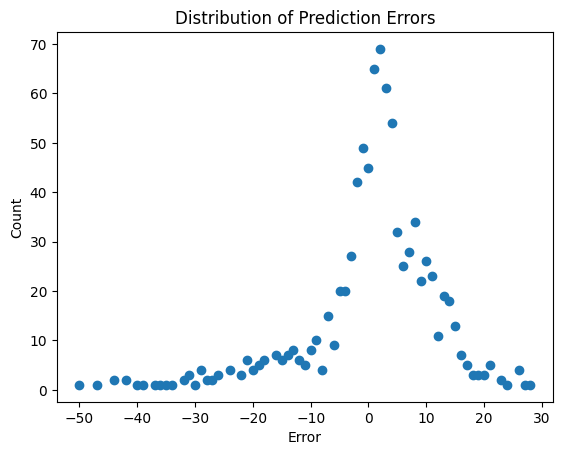

In [264]:
X_train_val_df = step4_dev_norm_df.copy()
# X_train_val_df = X_train_val_df

forest = RandomForestRegressor(n_estimators=300, n_jobs=5, random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.3, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.224589931506381

10.502778562698253

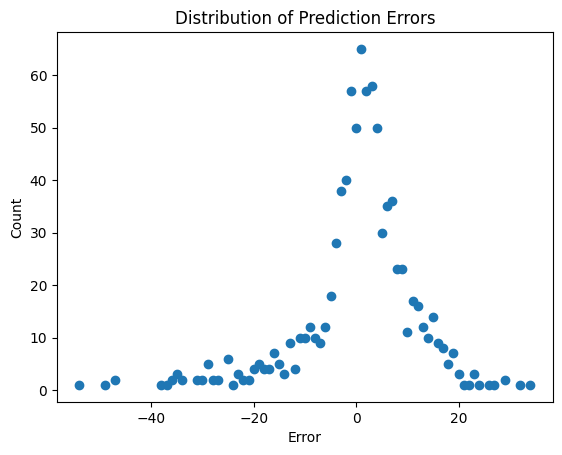

In [265]:
X_train_val_df = step4_dev_norm_df.copy()
# X_train_val_df = X_train_val_df.drop(columns=['age'], axis=1)

# forest = RandomForestRegressor(n_estimators=800, n_jobs=5, random_state=341967)
hist = HistGradientBoostingRegressor(random_state=341967, categorical_features=X_train_val_df.dtypes == 'object')

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.3, shuffle=True, random_state=341967)

hist.fit(X_train, y_train)
y_pred = hist.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.224589931506381

In [266]:
imps = sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)
imps

[('silence_duration', np.float64(0.23256025349371398)),
 ('lowest_freq_in_spectrum', np.float64(0.026656790260230545)),
 ('words_per_second', np.float64(0.024164132671474783)),
 ('char_per_second', np.float64(0.021882230849237048)),
 ('jitter', np.float64(0.012591561938477729)),
 ('mfcc_frequency_mean_30', np.float64(0.01162767213760511)),
 ('mfcc_frequency_mean_4', np.float64(0.011257348272693712)),
 ('mfcc_frequency_mean_27', np.float64(0.01091595245662058)),
 ('mfcc_frequency_mean_31', np.float64(0.010852092702581563)),
 ('mfcc_frequency_mean_10', np.float64(0.010470189801910765)),
 ('hnr', np.float64(0.010407676092632476)),
 ('mfcc_frequency_mean_22', np.float64(0.010335102298328373)),
 ('mfcc_frequency_mean_7', np.float64(0.009860087904605071)),
 ('dominant_frequency', np.float64(0.009635480076653512)),
 ('harmonic_frequency_mean_25', np.float64(0.009329673282498594)),
 ('num_pauses', np.float64(0.009233121398145788)),
 ('harmonic_frequency_mean_24', np.float64(0.00909323343482234

In [267]:
print(sum([imp for f, imp in imps[:81]]))

mean_imps = np.mean([imp for f, imp in imps])

print(len([f for f, imp in imps if imp > mean_imps]))

drop_features = [f for f,imp in imps[81:]]
# drop_features.append('audio_length')
drop_features

0.7829813778242827
46


['percussion_frequency_mean_23',
 'mel_frequency_mean_20',
 'harmonic_frequency_mean_5',
 'mel_frequency_mean_2',
 'harmonic_frequency_mean_16',
 'spect_frequency_mean_26',
 'harmonic_frequency_mean_15',
 'harmonic_frequency_mean_11',
 'spectral_centroid_mean',
 'harmonic_frequency_mean_4',
 'mel_frequency_mean_25',
 'harmonic_frequency_mean_0',
 'harmonic_frequency_mean_28',
 'mel_frequency_mean_16',
 'mel_frequency_mean_19',
 'harmonic_frequency_mean_8',
 'harmonic_frequency_mean_7',
 'harmonic_frequency_mean_21',
 'spectrum_wide',
 'spect_frequency_mean_10',
 'mel_overall_mean',
 'mel_frequency_mean_22',
 'harmonic_frequency_mean_9',
 'spect_frequency_mean_0',
 'percussion_frequency_mean_15',
 'spect_frequency_mean_11',
 'spect_frequency_mean_31',
 'spect_frequency_mean_28',
 'mel_frequency_mean_24',
 'harmonic_frequency_mean_19',
 'harmonic_frequency_mean_3',
 'highest_freq_in_spectrum',
 'mel_frequency_mean_23',
 'harmonic_frequency_mean_13',
 'mel_frequency_mean_26',
 'harmonic_f

In [268]:
step4_dev_pruned_df = step4_dev_norm_df.drop(columns=drop_features, axis=1)
step4_eval_pruned_df = step4_eval_norm_df.drop(columns=drop_features, axis=1)

# step4_dev_pruned_df = step4_dev_norm_df.copy()
# step4_eval_pruned_df = step4_eval_norm_df.copy()

10.567746507951123

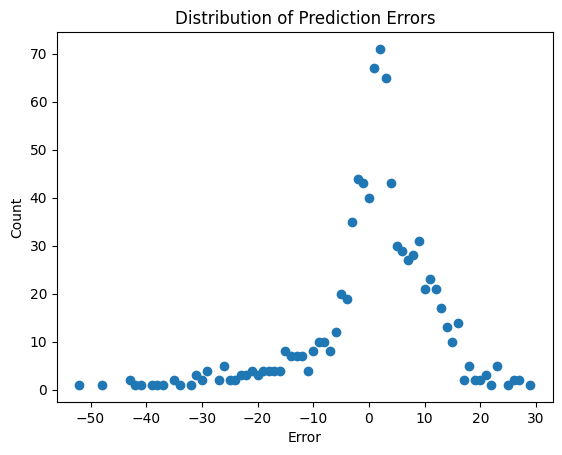

In [269]:
# let us try remove them
X_train_val_df = step4_dev_pruned_df.copy()
X_train_val_df = X_train_val_df

forest_pruned = RandomForestRegressor(n_estimators=300, n_jobs=5, random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.3, shuffle=True, random_state=341967)

forest_pruned.fit(X_train, y_train)
y_pred = forest_pruned.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.186472864996084

In [270]:
sorted(zip(forest_pruned.feature_names_in_, forest_pruned.feature_importances_), key=lambda x:x[1] , reverse=True)

[('silence_duration', np.float64(0.2361296183089283)),
 ('lowest_freq_in_spectrum', np.float64(0.031503874227730384)),
 ('words_per_second', np.float64(0.028547571356740378)),
 ('char_per_second', np.float64(0.021705020328495285)),
 ('jitter', np.float64(0.016104015539850816)),
 ('mfcc_frequency_mean_27', np.float64(0.014836614848810709)),
 ('mfcc_frequency_mean_4', np.float64(0.014507792082903226)),
 ('mfcc_frequency_mean_30', np.float64(0.014241463000652292)),
 ('mfcc_frequency_mean_10', np.float64(0.014035455227711133)),
 ('mean_pitch', np.float64(0.01339504329060575)),
 ('mfcc_frequency_mean_31', np.float64(0.01330001542432622)),
 ('hnr', np.float64(0.01321008249720325)),
 ('mfcc_frequency_mean_22', np.float64(0.012480909960284751)),
 ('mfcc_frequency_mean_7', np.float64(0.01238026018919942)),
 ('mfcc_frequency_mean_6', np.float64(0.012348262094667356)),
 ('harmonic_frequency_mean_25', np.float64(0.012169479828815614)),
 ('dominant_frequency', np.float64(0.012056166905588684)),
 ('

In [271]:
X_train_male, X_train_female = split_gender(step4_dev_norm_df)
ages_male, ages_female = split_ages(step4_dev_norm_df, ages_df)

reg_male, reg_female = gender_regs(X_train_male, X_train_female, ages_male, ages_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
4,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,-0.151479,-0.099722,0.418993,-0.582905,0.114856,-0.581158,0.190268,0.267847,0.597198,0.229116,-0.347467,-0.389014,0.008921,0.100869,0.667028,1.351876,1.310821,1.200526,0.668323,-0.059131,-0.518333,-0.494828,-0.332895,-0.191578,0.051954,0.443417,0.745608,0.657551,0.306650,-0.073895,-0.163395,...,-0.224269,-0.292482,0.111768,0.362287,0.459440,0.386954,0.508089,0.325428,0.172489,0.075548,0.133198,0.045616,-0.064218,-0.112897,-0.178566,-0.084650,0.065351,0.165087,0.213946,0.171898,0.113767,0.161388,0.203551,0.191176,0.122003,0.063019,0.021731,-0.033871,-0.071057,-0.086314,-0.073338,-0.049806,-0.035726,-0.045552,0.037653,0.575739,0.262986,-1.018814,1.312880,1.249290
6,1.248002,0.412951,-0.401807,0.285230,1.065699,-0.885193,1.224996,1.001083,-0.970233,-1.517644,1.161597,0.770379,-0.072279,0.008446,0.190131,-0.017345,-0.786494,-1.055750,-1.065655,-0.936462,-0.713446,-0.336950,-0.140071,-0.184657,0.065723,0.300195,0.206085,0.399635,0.332190,0.237901,0.159030,0.043610,-0.051640,-0.049755,0.044764,0.066257,-0.040720,-0.071098,0.030962,0.120683,...,-0.302310,-0.374134,0.468117,0.812909,0.713546,0.302653,0.043159,-0.008744,-0.135867,-0.122861,-0.011204,0.092973,0.062408,0.092167,0.117613,0.153989,0.170196,0.203765,0.306367,0.471341,0.495299,0.441189,0.388234,0.361403,0.310398,0.278157,0.252502,0.216765,0.183832,0.139841,0.128431,0.109013,0.029241,-0.080561,1.410955,-0.509318,-0.339413,-1.131255,0.320584,0.280246
9,-1.093927,0.391362,0.271042,-0.450725,0.356010,0.803222,-0.415347,-0.704939,-1.152218,0.714920,-0.800455,-1.113123,-0.515232,0.115526,-0.694175,0.206131,0.580728,1.134956,0.590419,0.277670,0.320352,0.590270,0.097350,0.197371,0.144416,-0.141925,0.374563,0.749175,0.489085,0.205465,0.077221,-0.096193,-0.158708,-0.279170,-0.398674,-0.442040,-0.482371,-0.502810,-0.475362,-0.431052,...,0.303186,-0.168944,0.248263,0.702724,1.410602,2.102506,2.175960,1.701368,1.217260,1.043151,0.882195,1.718888,2.330646,1.474024,0.379370,-0.143657,-0.370164,-0.288801,-0.193968,-0.036985,0.076334,0.059478,-0.007467,-0.019840,-0.019554,0.062483,0.157843,0.161718,0.150359,0.096751,0.0185

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,1.862330,0.954642,1.327894,-0.301255,2.435581,-0.621678,-0.597478,-1.242956,-0.987757,-0.424440,0.527754,0.887412,0.404501,0.230277,0.420465,0.690253,0.431868,0.017823,0.086242,0.079350,-0.285810,-0.586816,-0.681605,-0.625618,-0.497324,-0.429895,-0.348431,-0.157438,0.080994,0.115811,...,-0.329154,-0.351707,0.978197,0.980590,0.539739,0.296976,0.311208,0.074792,0.118172,0.153783,0.111857,0.155441,0.187506,0.105655,-0.069616,-0.260302,-0.410468,-0.579481,-0.646734,-0.611466,-0.487242,-0.377889,-0.326924,-0.353408,-0.349771,-0.326964,-0.263849,-0.204255,-0.141510,-0.091011,-0.058179,-0.088360,-0.153126,-0.225357,2.039962,-0.678260,0.003154,1.126899,-0.197371,-0.225573
1,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,0.601010,0.543263,-0.109528,0.027451,0.052437,0.019728,0.562547,0.905155,0.789437,0.561367,0.647430,0.313440,0.565612,0.630925,0.806721,0.710418,-0.059090,-0.363712,-0.265302,-0.002396,-0.080268,-0.365787,-0.565798,-0.723426,-0.725798,-0.705868,-0.660981,-0.613170,-0.588894,-0.566910,...,-0.350050,-0.361253,0.060830,0.441999,0.521555,0.805936,1.008057,0.843677,0.839530,0.575269,0.434254,0.049028,-0.217937,-0.109264,-0.060968,-0.071022,-0.185749,-0.419093,-0.567990,-0.614885,-0.607557,-0.572708,-0.547415,-0.556360,-0.572857,-0.576756,-0.570614,-0.571207,-0.565445,-0.550520,-0.540773,-0.520799,-0.475700,-0.450814,-0.517137,0.566580,0.813061,0.654294,0.710913,0.661428
2,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,-0.800455,0.751095,-0.776157,0.117258,-0.598683,0.194970,-0.179217,-0.047052,-0.247578,-0.417702,-0.453974,-0.090468,0.035952,-0.354046,-0.445564,-0.047697,0.171123,-0.107342,-0.229280,-0.288128,-0.206941,-0.146881,-0.087851,0.193343,0.425399,0.464089,0.267721,0.311953,0.395230,0.337627,...,0.193246,0.042198,-0.447319,-0.275886,-0.022262,0.079994,-0.205221,-0.249251,-0.282268,-0.320338,-0.122745,-0.086239,-0.028237,-0.033572,-0.053769,-0.064480,-0.056498,-0.037569,-0.032997,0.019845,0.155596,0.320530,0.377715,0.408559,0.393956,0.417690,

10.922874220107058

# Upload section

In [272]:
# y_eval_pred = forest_pruned.predict(step4_eval_pruned_df)
X_eval_male, X_eval_female = split_gender(step4_eval_norm_df)

y_eval_pred_male = reg_male.predict(X_eval_male)
y_eval_pred_female = reg_female.predict(X_eval_female)

y_eval_pred = merge_genders(y_eval_pred_male, y_eval_pred_female, index_male=X_eval_male.index, index_female=X_eval_female.index)
display(y_eval_pred)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,-19.186828,-7.093777,-39.216378,15.394010,24.438343,5.606421,-3.622150,-36.389369,-3.738796,1.910239,-0.921709,-1.035520,-0.822620,0.008801,0.187367,-0.016626,-0.174548,0.306593,-0.075705,-0.406809,-0.135741,-0.084396,-0.035119,-0.059031,-0.032868,0.237248,0.209990,-0.183895,-0.354216,-0.515302,-0.659096,-0.688095,-0.660717,-0.576809,-0.502914,-0.472247,-0.444524,-0.409305,-0.343552,-0.341683,...,-0.640532,-0.543987,-0.185335,-0.318359,-0.157713,-0.177654,-0.178255,-0.174851,-0.207242,-0.136601,-0.156807,-0.218603,-0.244587,-0.318127,-0.388977,-0.487427,-0.549298,-0.523380,-0.377896,-0.297790,-0.319931,-0.373496,-0.419620,-0.484799,-0.548979,-0.570178,-0.566551,-0.566751,-0.584624,-0.629155,-0.671135,-0.701837,-0.741841,-0.761459,-1.411764,-0.353486,-0.141627,-0.144316,-1.993820,-1.965106
1,-16.762242,-7.093587,-39.203853,20.243094,16.255260,7.429258,6.794064,-24.119654,-3.731487,1.936231,-0.798952,-1.108686,0.204179,0.130162,-0.692508,0.220186,0.648044,0.916194,0.665016,-0.019018,-0.390697,-0.088333,-0.107092,-0.103065,0.226158,0.041955,-0.186879,0.244199,0.407574,0.542665,0.928316,1.113102,1.061620,0.821135,0.391095,0.233833,0.282940,0.566148,0.808200,0.925782,...,0.009349,-0.355657,-0.239910,-0.200064,-0.094307,0.099648,0.099749,0.112363,0.029732,0.053911,0.198346,0.167888,0.340523,0.626411,0.761247,0.954344,0.972975,1.021883,0.983243,0.953278,0.883255,0.992508,1.043888,1.091266,1.069715,1.087281,1.067375,1.132725,1.161715,1.258337,1.261741,1.222386,0.910574,0.471550,0.361356,0.343629,0.335688,-0.647425,-1.992790,-1.961008
2,-20.737616,-7.095538,-39.196102,10.102150,5.985827,6.448321,4.204857,-29.740139,-3.701787,1.940714,-0.921709,-1.341386,-0.393298,0.117136,-0.694175,0.207701,0.212112,0.215721,0.021599,-0.038289,0.561884,0.823539,0.470644,0.431693,0.490027,-0.026955,-0.352435,-0.230219,-0.245562,-0.397959,-0.054892,0.354140,0.470382,0.200646,0.265534,0.514598,0.297686,0.146191,0.154582,0.189395,...,-0.143801,-0.260716,0.161545,0.236136,0.342682,0.732690,0.736434,0.658430,0.699027,0.495549,0.354725,0.164375,0.299043,0.367821,0.268639,0.570086,0.516636,0.358934,0.230022,0.290121,0.286561,0.376612,0.521097,0.531748,0.480405,0.499225,0.36

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
3,-14.775719,-7.093588,-39.214626,20.942970,3.422789,9.287145,4.873228,-31.429445,-3.701787,1.920477,-0.779311,-1.172149,-0.371964,-0.156830,1.388428,-0.339852,1.052848,2.011071,1.585917,0.543093,-0.205579,0.160347,0.344253,0.325834,0.451156,0.406064,-0.099631,0.027461,0.259128,0.117556,-0.067799,-0.089979,-0.069089,-0.325604,-0.454618,-0.438112,-0.394419,-0.319118,-0.351168,-0.387503,...,-0.333604,-0.371648,-0.047893,0.147634,0.445611,0.536061,0.344239,0.378605,0.316015,0.284959,0.245400,0.045206,-0.073860,-0.061928,-0.228482,-0.374794,-0.373398,-0.341554,-0.280736,-0.241146,-0.197022,-0.173131,-0.167287,-0.187071,-0.236268,-0.278445,-0.304912,-0.317609,-0.327829,-0.329503,-0.318519,-0.303663,-0.290454,-0.315288,-0.161951,1.087977,1.406863,-0.416097,-1.992764,-1.960905
5,-19.390695,-7.093674,-38.696657,19.449329,9.909256,2.850339,0.545802,-32.944686,-3.690455,1.931358,-0.926619,-1.339277,0.344027,0.008517,-0.694175,0.101721,-0.862236,-0.951377,-0.931892,-0.909496,-0.703617,-0.211819,0.179086,0.697406,0.506086,-0.312053,-0.461901,-0.076960,0.333284,0.447625,0.191777,-0.378606,-0.793347,-0.886275,-0.881055,-0.862809,-0.846717,-0.826363,-0.774884,-0.701822,...,-0.516041,-0.471899,0.165638,0.129759,0.351811,0.243714,-0.222382,-0.147009,-0.081508,-0.101437,-0.230774,-0.192066,0.101829,0.229361,0.034582,-0.327732,-0.511667,-0.767236,-0.925006,-1.008286,-1.019297,-0.992276,-0.948147,-0.873639,-0.825729,-0.801455,-0.769187,-0.749393,-0.734894,-0.727308,-0.718554,-0.717425,-0.698078,-0.690705,-0.953722,-1.000569,-0.970960,1.647216,-2.104018,-2.410029
6,-11.802188,-7.093586,-39.196657,14.518413,3.605422,6.743634,8.337665,-22.174231,-3.676455,1.913611,-0.794042,-1.195083,0.122738,-0.015906,0.366725,-0.064868,-0.038833,-0.237250,0.124633,0.216286,-0.024739,0.373084,0.231602,-0.137051,-0.155562,-0.098373,-0.160326,-0.204779,-0.168288,-0.122246,-0.108449,-0.020425,-0.074847,-0.213017,-0.256405,-0.145875,-0.078921,-0.093414,-0.251225,-0.281559,...,-0.311947,-0.287820,-0.026571,-0.067489,-0.162780,-0.101452,0.027754,-0.193753,-0.159972,-0.128728,-0.092923,-0.138262,-0.137876,-0.135791,-0.163718,-0.121235,-0.085007,-0.052775,-0.028269,0.008732,-0.007591,0.00

0      28.87
1      24.74
2      21.95
3      22.92
4      26.92
       ...  
686    21.38
687    23.95
688    23.40
689    32.75
690    20.56
Length: 691, dtype: float64

In [274]:
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")